# Parametric Analysis
---
*A derivation of the asymptotic distribution of random search*

See [**Formalizing the Problem**](./formalizing-the-problem.ipynb) for basic notation and definitions.

In [1]:
# imports

from autograd import grad, hessian
from matplotlib import pyplot as plt
import numpy as np
from scipy import optimize, stats

from experiments.analytic import get_approximation_parameters
from experiments.simulation import Simulation, make_damped_linear_sin
from experiments.visualization import (
    plot_distribution_approximation,
    plot_tuning_curve_approximation,
)
from opda.parametric import NoisyQuadraticDistribution, QuadraticDistribution
import opda.random

# constants

styles = {
    "empirical": {"linestyle": "--", "color": "#648FFF"},
    "theoretical": {"linestyle": "-", "color": "#FFB000"},
}

n_trials = 4_096
n_samples = 256

sample_sizes = [4, 16, 64, 256]

func_1d = make_damped_linear_sin(scale=-1, weights=[1], bias=0)
bounds_1d = [(-1, 1)]

func_3d = make_damped_linear_sin(scale=-1, weights=[1, 2, 1], bias=0)
bounds_3d = [(-1, 1)] * 3

max_n_dims = 5


# Configure environment.

generator = np.random.RandomState(0)
opda.random.set_seed(generator)


# Configure Matplotlib.

plt.style.use("experiments.default")

## Extrapolating Random Search

Imagine you're minimizing a score via random search. Perhaps you're tuning a language model's hyperparameters to minimize negative log-likelihood. After you've run a few rounds of search, a natural question is: what happens if you just keep going?

To answer this question, consider the distribution over validation scores you get by randomly sampling hyperparameters then training and evaluating the model, i.e. *the score distribution*:

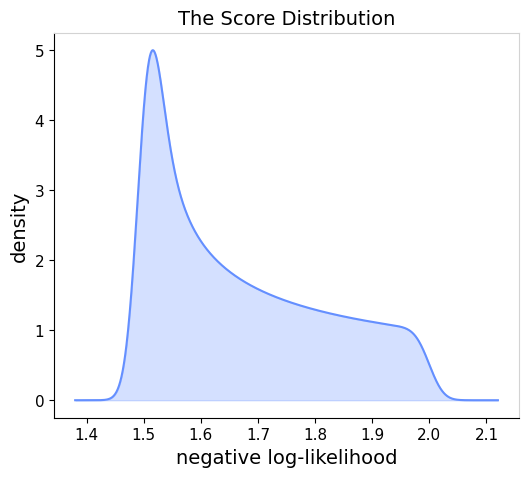

In [2]:
# Visualize an idealized score distribution.

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

a, b, c, o, convex = 1.5, 2., 1, 2e-2, True
dist = NoisyQuadraticDistribution(a, b, c, o, convex)

grid = np.linspace(a - 6 * o, b + 6 * o, num=1_024)

# Plot the distribution.
ax.plot(
    grid,
    dist.pdf(grid),
    linestyle="-",
    color=styles["empirical"]["color"],
)
ax.fill_between(
    grid,
    dist.pdf(grid),
    alpha=0.275,
    color=styles["empirical"]["color"],
)

# Format the plot.
ax.grid(visible=False)
ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")

ax.set_xlabel("negative log-likelihood")
ax.set_ylabel("density")
ax.set_title("The Score Distribution")

plt.show()

The result from $k$ rounds of random search shares a simple algebraic relationship with the result from 1 round:

$$
\begin{align*}
  F_k(y) &= \mathbb{P}\left(\min_{i=1\ldots k} Y_i\leq y\right) \\
         &= 1 - \mathbb{P}\left(\min_{i=1\ldots k} Y_i > y\right) \\
         &= 1 - \mathbb{P}\left(Y_1 > y \land \ldots \land Y_k > y\right) \\
         &= 1 - \prod_{i=1}^k \mathbb{P}\left(Y_i > y\right) \\
         &= 1 - \prod_{i=1}^k \left(1 - F(y)\right) \\
         &= 1 - (1 - F(y))^k
\end{align*}
$$

Or, more compactly:

$$ F_k(y) = 1 - \left(1 - F(y)\right)^k $$

At the same time, if the best score so far is $y_0$, then you only care about scores better than it&mdash;in other words, the left *tail* of the distribution. Putting these two facts together, we see that as the random search continues its behavior is increasingly determined by the tail of the score distribution.

To extrapolate random search, we need to find a parametric form for this distribution's tail.

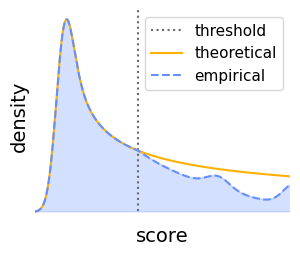

In [3]:
# Illustrate a parametric form fitting the distribution's tail.

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.3, 2.75))

a, b, c, o, convex, threshold = 0., 1., 1, 3e-2, True, 0.3
dist_tl = NoisyQuadraticDistribution(a, b, c, o, convex)
dist_bd = stats.gaussian_kde(
    # Use a KDE to create something complicated for the distribution's body.
    [0.] * 20 + [0.6, 0.9],
    bw_method=2e-1,
)

ys_grid = np.linspace(a - 6 * o, b + 6 * o, num=4_096)

ws = np.clip((b - ys_grid) / (b - threshold), 0., 1.)

# Plot the theoretical approximation.
ax.axvline(
    threshold,
    ymin=0.05,
    linestyle=":",
    c="dimgray",
    label="threshold",
)
ax.plot(
    ys_grid,
    dist_tl.pdf(ys_grid),
    label="theoretical",
    **styles["theoretical"],
)

# Plot the empirical ground truth.
ax.plot(
    ys_grid,
    ws * dist_tl.pdf(ys_grid) + (1 - ws) * dist_bd.pdf(ys_grid),
    label="empirical",
    **styles["empirical"],
)
ax.fill_between(
    ys_grid,
    ws * dist_tl.pdf(ys_grid) + (1 - ws) * dist_bd.pdf(ys_grid),
    alpha=0.275,
    color=styles["empirical"]["color"],
)

# Format the plot.
y_min_ = a - 3 * o

x_lim_cdf = (
    y_min_ - 0.025 * (threshold - y_min_),
    y_min_ + 2.5 * (threshold - y_min_),
)

ax.set_xlim(*x_lim_cdf)
ax.set_xlabel("score")
ax.set_ylabel("density")

ax.set_xticks([])
ax.set_yticks([])

ax.grid(visible=False)
ax.spines["left"].set_color(None)
ax.spines["right"].set_color(None)
ax.spines["top"].set_color(None)
ax.spines["bottom"].set_color(None)

ax.legend()

plt.show()

We want some parametric structure that describes the tail, even if the rest of the distribution diverges from it.

### Approximating the Tail

Often, we get such parametric forms from some kind of limit theorem, like how the normal distribution arises from the central limit theorem. In a similar way, we will see that the score distribution's tail obeys its own kind of limit theorem, leading to a new distribution family.

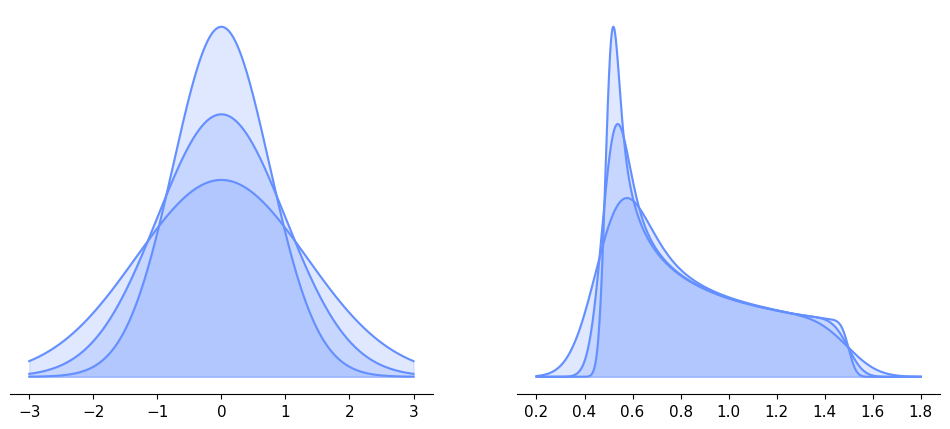

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i, (x_lims, dists) in enumerate([
    ((-3.0, 3.0), [stats.norm(0., o) for o in [3/4, 1.0, 4/3]]),
    (( 0.2, 1.8), [NoisyQuadraticDistribution(0.5, 1.5, 1, o, True) for o in [2.5e-2, 5e-2, 1e-1]]),
]):
    grid = np.linspace(*x_lims, num=1_024)
    for dist in dists:
        # Plot the distribution.
        axes[i].plot(
            grid,
            dist.pdf(grid),
            linestyle="-",
            color=styles["empirical"]["color"],
        )
        axes[i].fill_between(
            grid,
            dist.pdf(grid),
            alpha=0.2,
            color=styles["empirical"]["color"],
        )

    # Format the plot.
    axes[i].grid(visible=False)
    axes[i].spines["left"].set_color(None)
    axes[i].spines["right"].set_color(None)
    axes[i].spines["top"].set_color(None)

    axes[i].set_yticks([])

plt.show()

Let's derive this limiting distribution.

Imagine the process of random search. As we sample more points, the best comes closer and closer to the optimal hyperparameters.

Let $\pmb{x}_*$ be the best possible hyperparameters:

$$ \pmb{x}_* = \mathop{\mathrm{arg\,min}}_{\pmb{x}\in \mathcal{X}}\; g(\pmb{x}) $$

Assuming $g$ is sufficiently smooth, we can Taylor expand it about $\pmb{x}_*$ to second order:

$$ g(\pmb{x}) \approx g(\pmb{x}_*) + \nabla g_{\pmb{x}_*} (\pmb{x} - \pmb{x}_*) + \frac{1}{2} (\pmb{x} - \pmb{x}_*)^T H_{\pmb{x}_*} (\pmb{x} - \pmb{x}_*) $$

As the current best hyperparameters come closer and closer to $\pmb{x}_*$, the Taylor expansion becomes a better and better approximation in the region of interest.

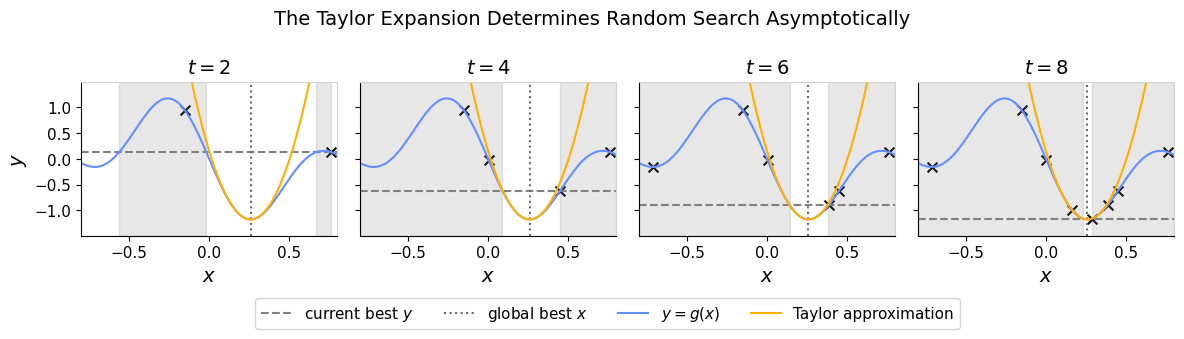

In [5]:
x_lims = (-0.8, 0.8)
y_lims = (-1.5, 1.5)

n_grid = 1_024
grid = np.linspace(*x_lims, num=n_grid).reshape(n_grid, 1)

y_argmin = grid[np.argmin(func_1d(grid))]

# Use the following data points for illustrative purposes.
xs_all = np.array([-0.152, 0.763, 0.003, 0.451, 0.385, -0.712, 0.288, 0.163])
ys_all = func_1d(xs_all.reshape(-1, 1))

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), sharex=True, sharey=True)
for i in range(len(xs_all) // 2):
    xs, ys = xs_all[:2*(i+1)], ys_all[:2*(i+1)]
    y_min = np.min(ys)

    axes[i].axhline(
        y_min,
        linestyle="--",
        c="grey",
        label=r"current best $y$",
    )
    axes[i].axvline(
        y_argmin,
        linestyle=":",
        c="dimgrey",
        label=r"global best $x$",
    )
    axes[i].scatter(
        xs,
        ys,
        marker="x",
        c="k",
        s=50,
    )

    axes[i].plot(
        grid,
        func_1d(grid),
        linestyle="-",
        c=styles["empirical"]["color"],
        label=r"$y = g(x)$",
    )
    axes[i].plot(
        grid,
        func_1d(y_argmin)
          + grad(func_1d)(y_argmin) * (grid - y_argmin)
          + 0.5 * hessian(func_1d)(y_argmin) * (grid - y_argmin)**2,
        linestyle="-",
        c=styles["theoretical"]["color"],
        label=r"Taylor approximation",
    )

    x_start = x_lims[0]
    x_end = None
    for (x,) in grid:
        y = func_1d([[x]])
        if y < y_min and x_end is not None:
            axes[i].axvspan(
                x_start,
                x_end,
                alpha=0.1875,
                color="grey",
            )
            x_end = None
        x_start = x if y < y_min else x_start
        x_end = x if y >= y_min else x_end

    if y >= y_min:
        axes[i].axvspan(
            x_start,
            x_end,
            alpha=0.1875,
            color="grey",
        )

    # Format the plot.
    axes[i].set_xlim(*x_lims)
    axes[i].set_ylim(*y_lims)
    axes[i].set_yticks(np.linspace(-1.0, 1.0, num=5))
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")
    axes[i].grid(visible=False)
    axes[i].set_xlabel(r"$x$")
    axes[i].set_title(rf"$t = {2*(i+1)}$")

axes[0].set_ylabel(r"$y$")

fig.suptitle("The Taylor Expansion Determines Random Search Asymptotically")

fig.tight_layout()

axes[0].legend(
    loc="upper left",
    bbox_to_anchor=(0.65, -.35),
    ncol=4,
)

plt.show()

Since $\pmb{x}_*$ is the minimum, we have $\nabla g_{\pmb{x}_*} = \pmb{0}$. Since the Hessian is symmetric and real, it's diagonalizable. Thus, $H_{\pmb{x}_*} = Q \Lambda Q^T$ where $\Lambda$ is diagonal and $QQ^T = I$ is orthogonal. In particular:

$$
\begin{align*}
g(\pmb{x}) &\approx g(\pmb{x}_*) + \frac{1}{2} (\pmb{x} - \pmb{x}_*)^T Q\Lambda Q^T (\pmb{x} - \pmb{x}_*) \\
           &= y_* + \frac{1}{2} (\pmb{x}' - \pmb{x}'_*)^T \Lambda (\pmb{x}' - \pmb{x}'_*) \\
           &= y_* + \frac{1}{2} \sum_{j=1}^d \lambda_j (x'^j - x'^j_*)^2 \\
\end{align*}
$$

Where $\pmb{x}' := Q^T \pmb{x}$ and $\pmb{x}'_* := Q^T \pmb{x}_*$ are obtained by a change of coordinates, $y_* := g(\pmb{x}_*)$, and $\lambda_j$ is the $j^{th}$ eigenvalue of the Hessian. This equation is the formula for an ellipse. Since $Q$ is orthogonal it's an isometry, so if $\pmb{X}_i$ is uniformly distributed then so is $\pmb{X}'_i = Q^T \pmb{X}_i$. Then, we have $\mathbb{P}(g(\pmb{X}_i) \leq y)$ is approximately proportional to the volume of the ellipse defined by:

$$ y_* + \frac{1}{2} \sum_{j=1}^d \lambda_j (x'^j - x'^j_*)^2 \leq y $$

Or, equivalently:

$$ \sum_{j=1}^d \frac{\lambda_j}{2} (x'^j - x'^j_*)^2 \leq y - y_* $$

The ellipse has volume:

$$
\begin{align*}
  V(y) &= (y - y_*)^{\frac{d}{2}} V(1 + y_*) \\
       &= (y - y_*)^{\frac{d}{2}} \left(\frac{\pi^{\frac{d}{2}}}{\Gamma\left(\frac{d}{2} + 1\right)}\prod_{j=1}^{d} \sqrt{\frac{2}{\lambda_j}}\right) \\
\end{align*}
$$

And the probability that $\pmb{X}_i$ falls in the ellipse is then:

$$ \mathbb{P}(g(\pmb{X}_i) \leq y) \approx V(y) \prod_{j=1}^{d} \frac{1}{b_j - a_j} $$

Thus, the CDF for the *left* tail when *minimizing* is approximately:

$$ F(y) = \mathbb{P}(Y_i \leq y) \approx V(y) \prod_{j=1}^{d} \frac{1}{b_j - a_j} $$

An analogous argument gives an approximation for the CDF of the *right* tail when *maximizing*:

$$ F(y) \approx 1 - V(y) \prod_{j=1}^{d} \frac{1}{b_j - a_j} $$

Where $y^*$ is the maximum and $V(y)$ equals:

$$ V(y) = (y^* - y)^{\frac{d}{2}} \left(\frac{\pi^{\frac{d}{2}}}{\Gamma\left(\frac{d}{2} + 1\right)}\prod_{j=1}^{d} \sqrt{-\frac{2}{\lambda_j}}\right) $$

Given these approximations to the CDF, we can obtain the PDF by taking derivatives, and so on.

### Evaluating the Approximation in Simulation

Let's see how well this approximation holds in an example. We'll simulate random search and then compare the tail against its approximation. In this simulation, we'll assume that we're *maximizing* and so we'll approximate the *right* tail.

First, we run the simulation and compute the approximation:

In [6]:
s = Simulation.run(
    n_trials=n_trials,
    n_samples=n_samples,
    n_dims=1,
    func=func_1d,
    bounds=bounds_1d,
    generator=generator,
)

dist = QuadraticDistribution(
    *get_approximation_parameters(
        func=s.func, bounds=s.bounds, generator=generator,
    ),
)

Next, we'll compare the true CDF to our approximation:

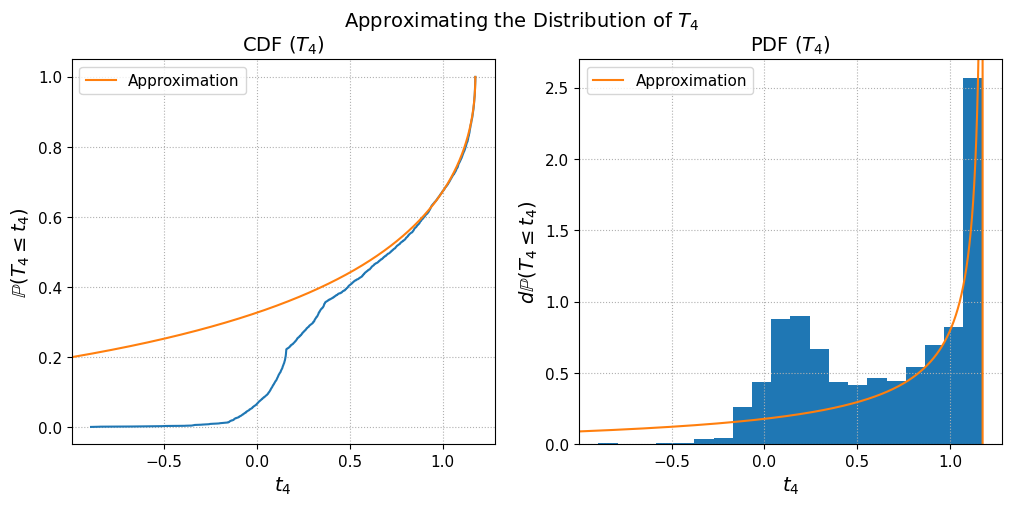

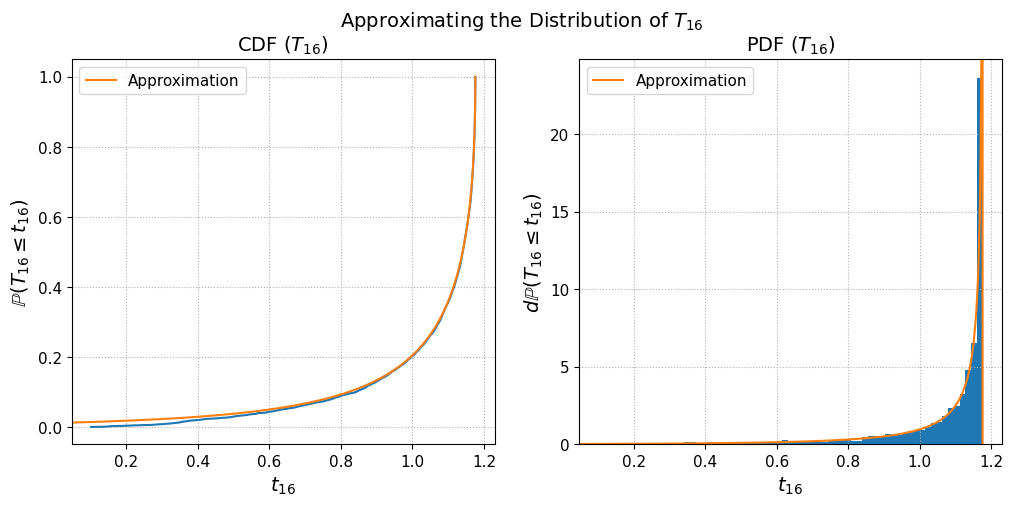

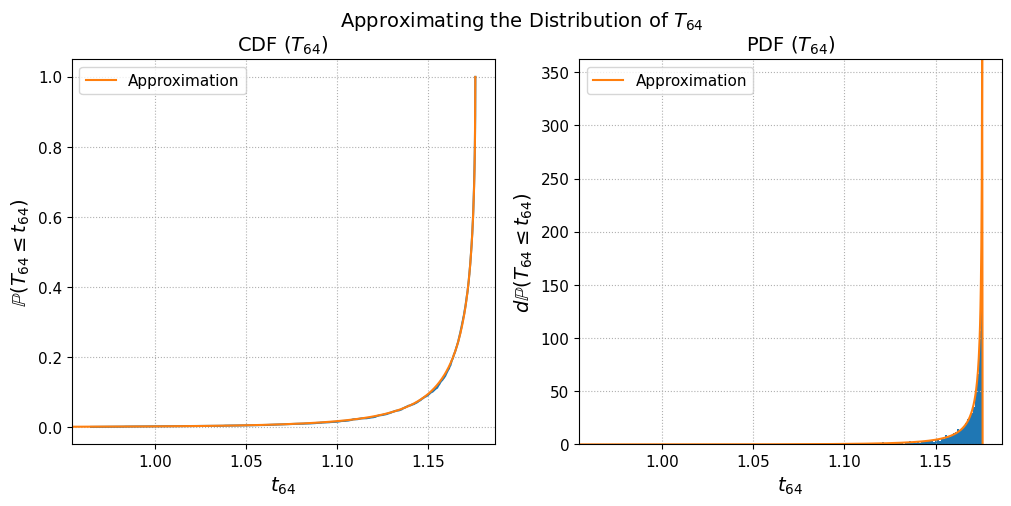

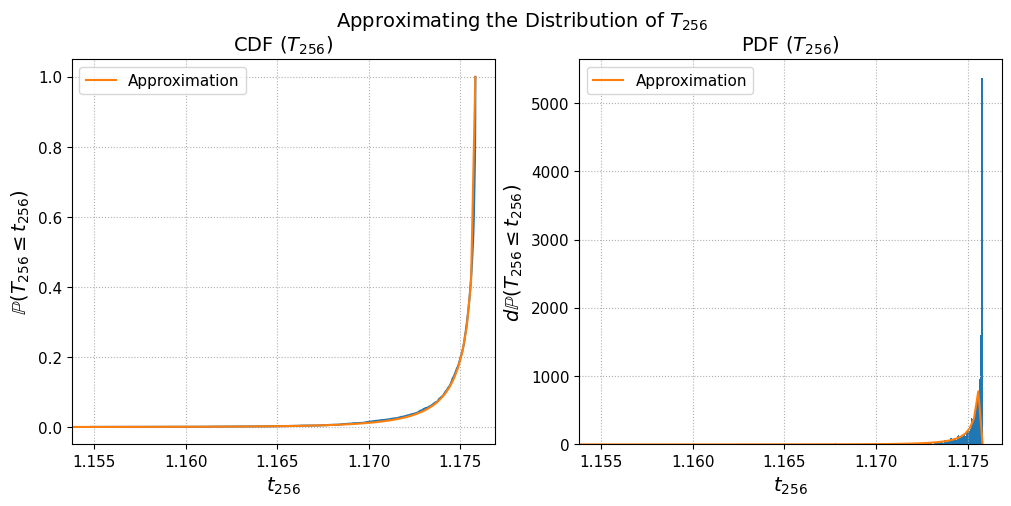

In [7]:
for n_samples_ in sample_sizes:
    fig, _ = plot_distribution_approximation(s, dist, n_samples_)
    fig.suptitle(f"Approximating the Distribution of $T_{{{n_samples_}}}$")
    plt.show()

The approximation fits the CDF's tail well, and quickly approximates the distribution of $T_{k}$. We can invert the approximate CDF's formula to obtain a closed-form for the asymptotic median tuning curve or more generally the $q^{th}$ quantile tuning curve, $\tau_q(k)$:

$$
\begin{align*}
                                 q &= \left(1 - V(y) \prod_{j=1}^{d} \frac{1}{b_j - a_j}\right)^k \\
                              V(y) &= \left(1 - q^\frac{1}{k}\right)\prod_{j=1}^{d} (b_j - a_j) \\
  (y^* - y)^\frac{d}{2} V(y^* - 1) &= \left(1 - q^\frac{1}{k}\right)\prod_{j=1}^{d} (b_j - a_j) \\
                         \tau_q(k) &= y^* - \left[\frac{\prod_{j=1}^{d} (b_j - a_j)}{V(y^* - 1)} \left(1 - q^\frac{1}{k}\right)\right]^\frac{2}{d} \\
\end{align*}
$$

We can similarly approximate the expected tuning curve, $\tau_e(k)$, though we'll defer that discussion until we define the *the quadratic distribution* below.

We've seen that the approximation captures the distribution of scores from random search. Let's see how it translates to the tuning curve:

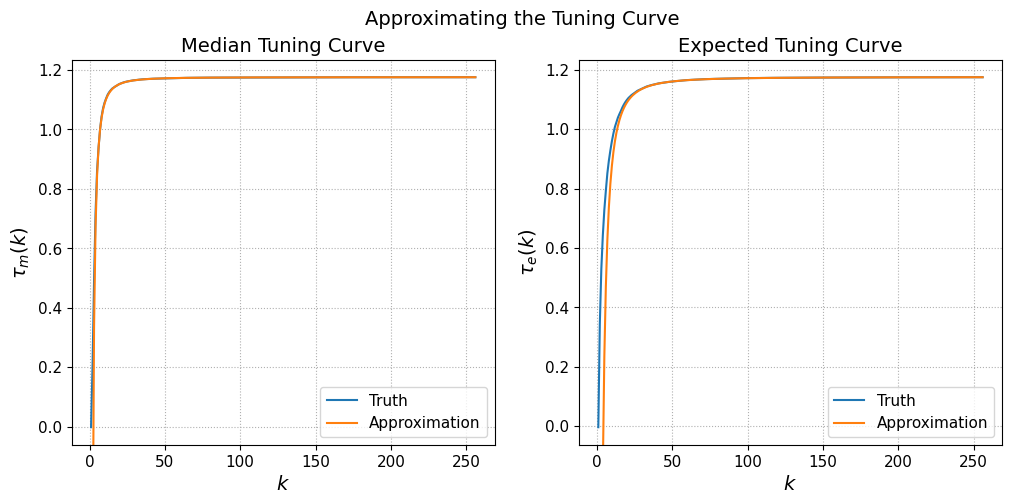

In [8]:
fig, _ = plot_tuning_curve_approximation(s, dist)
fig.suptitle("Approximating the Tuning Curve")
plt.show()

Not only does the approximation fit the CDF, it fits the tuning curve too.

Let's investigate the approximation's quality in higher dimensions:

In [9]:
s = Simulation.run(
    n_trials=n_trials,
    n_samples=n_samples,
    n_dims=3,
    func=func_3d,
    bounds=bounds_3d,
    generator=generator,
)

dist = QuadraticDistribution(
    *get_approximation_parameters(
        func=s.func, bounds=s.bounds, generator=generator,
    ),
)

Here's the CDF approximation:

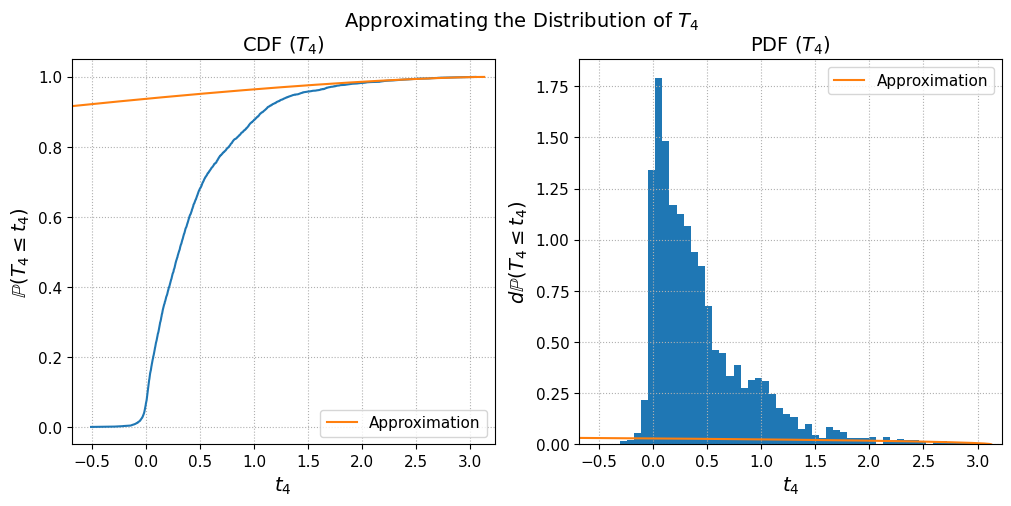

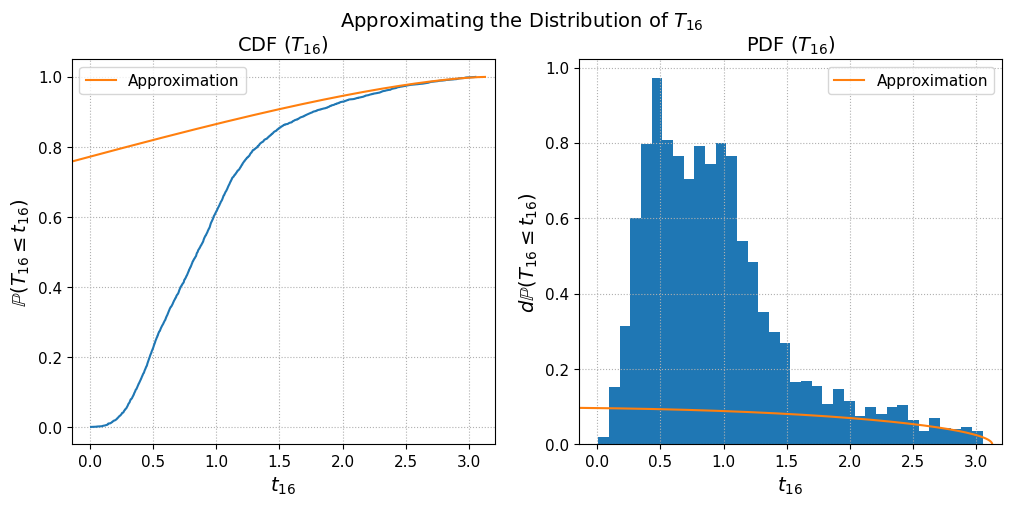

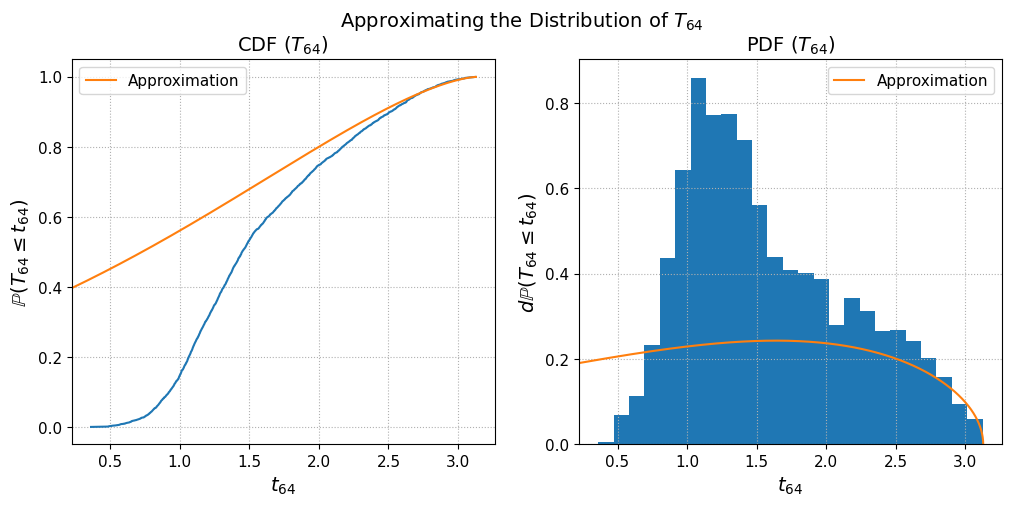

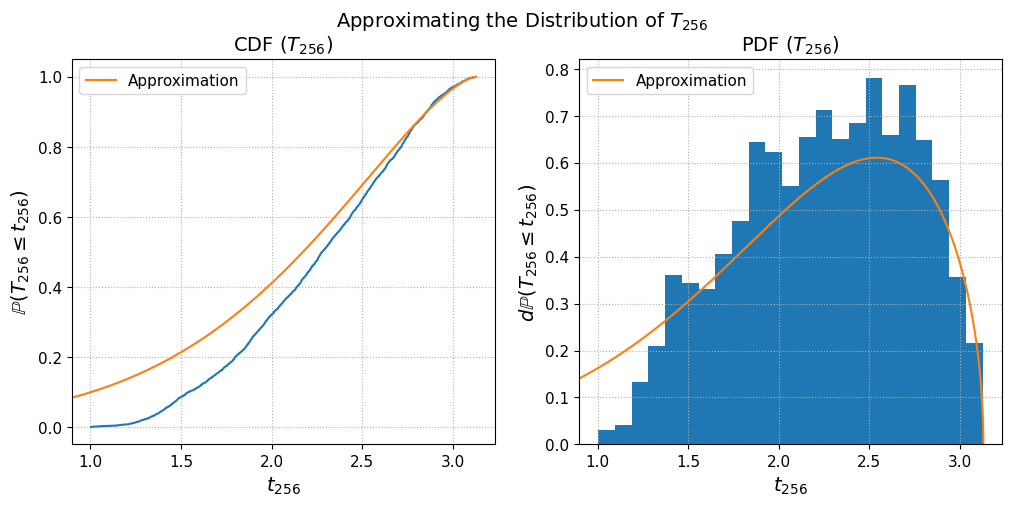

In [10]:
for n_samples_ in sample_sizes:
    fig, _ = plot_distribution_approximation(s, dist, n_samples_)
    fig.suptitle(f"Approximating the Distribution of $T_{{{n_samples_}}}$")
    plt.show()

And here are the tuning curve approximations:

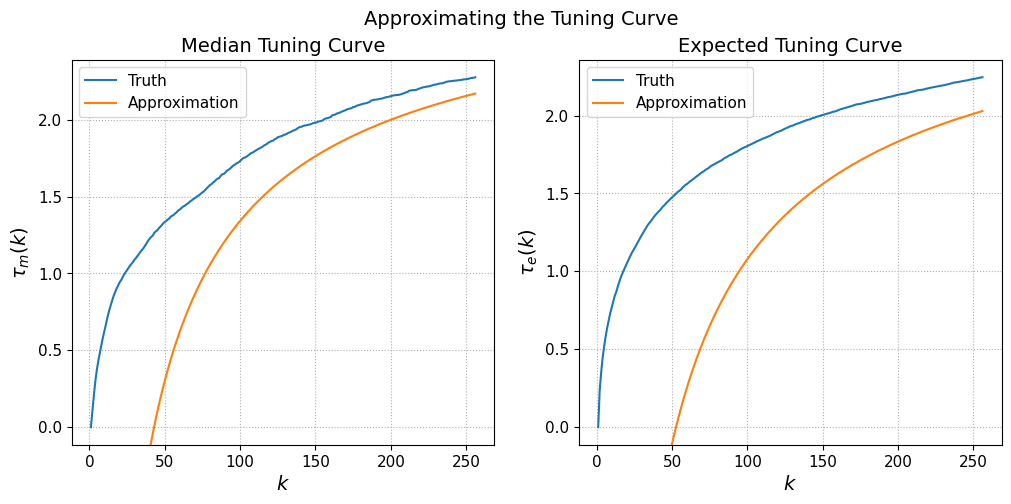

In [11]:
fig, _ = plot_tuning_curve_approximation(s, dist)
fig.suptitle("Approximating the Tuning Curve")
plt.show()

The approximation formula still works in higher dimensions, but begins to suffer from the curse of dimensionality&mdash;especially once you get above 3 or 4 dimensions; however, the approximation converges considerably faster if you tighten the search space around the optimum. Thus, one fix for higher dimensions is to inform your search by throwing out bad parts of the space.

Here's the same simulation with a tighter search space:

In [12]:
s = Simulation.run(
    n_trials=n_trials,
    n_samples=n_samples,
    n_dims=3,
    func=func_3d,
    bounds=[
        (x_opt - (hi - lo) / 4, x_opt + (hi - lo) / 4)
        for x_opt, lo, hi in zip(
            optimize.differential_evolution(
                func=lambda x: -func_3d(x),
                bounds=bounds_3d,
                seed=generator,
            ).x,
            *zip(*bounds_3d),
        )
    ],
    generator=generator,
)

dist = QuadraticDistribution(
    *get_approximation_parameters(
        func=s.func, bounds=s.bounds, generator=generator,
    ),
)

The CDF approximation:

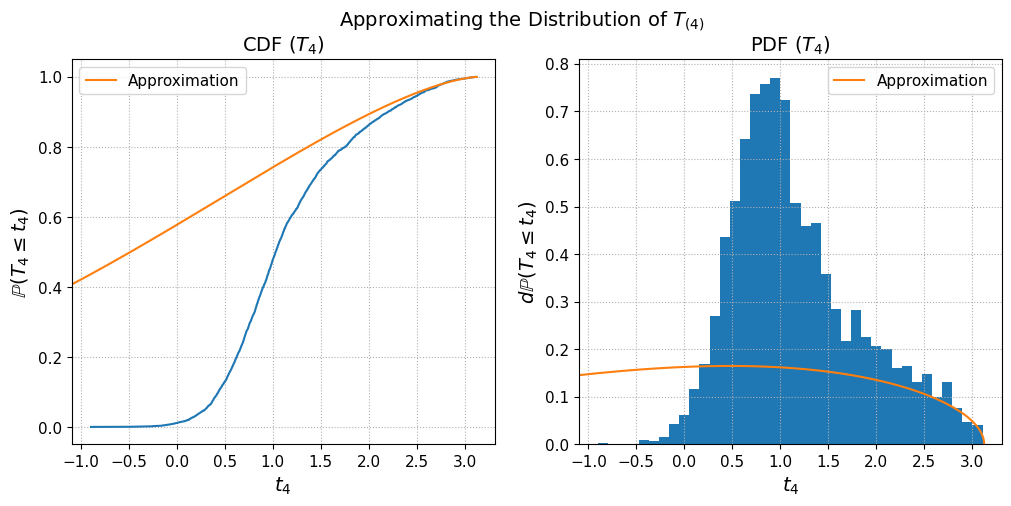

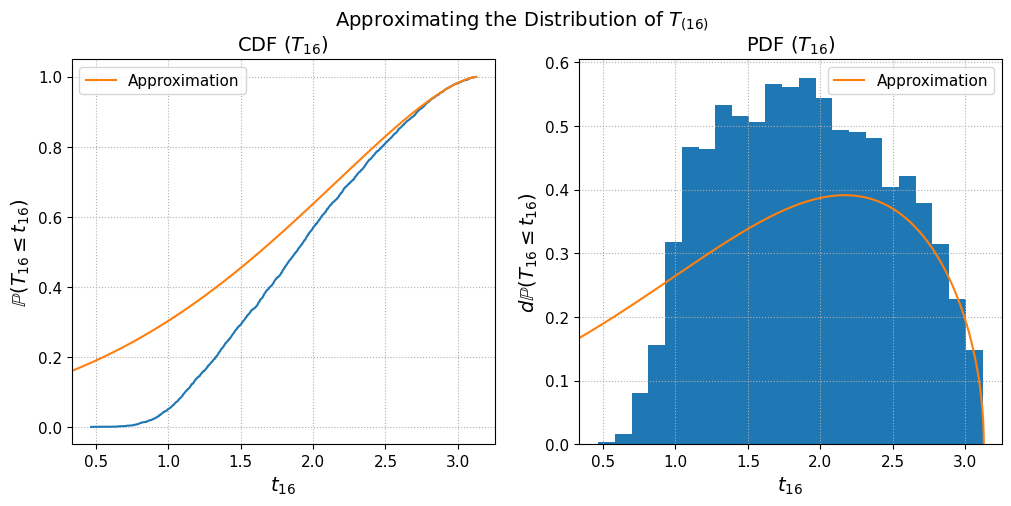

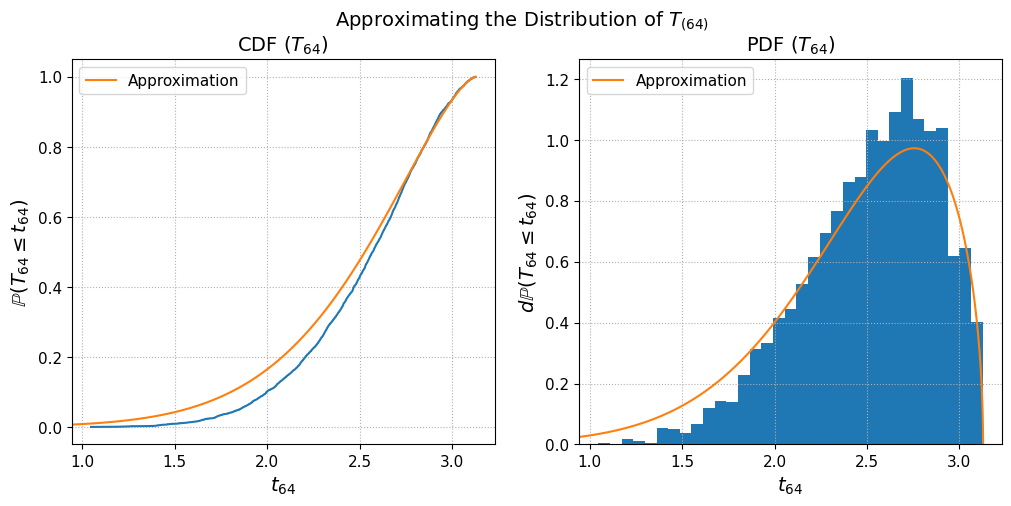

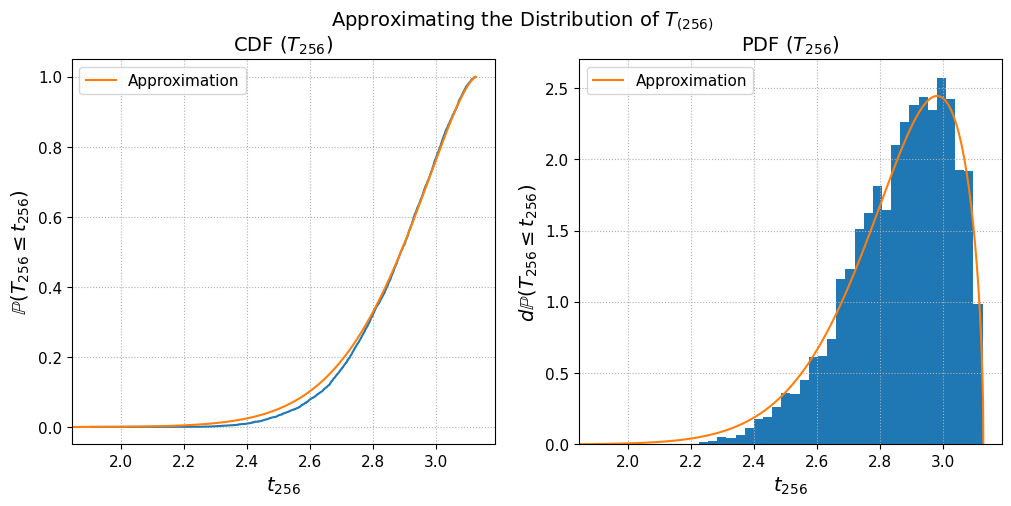

In [13]:
for n_samples_ in sample_sizes:
    fig, _ = plot_distribution_approximation(s, dist, n_samples_)
    fig.suptitle(f"Approximating the Distribution of $T_{{({n_samples_})}}$")
    plt.show()

The tuning curve approximations:

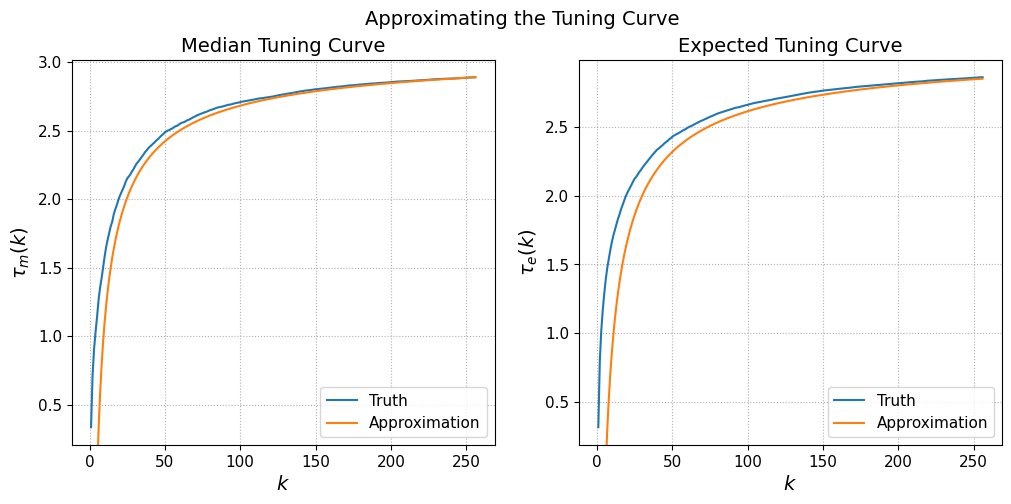

In [14]:
fig, _ = plot_tuning_curve_approximation(s, dist)
fig.suptitle("Approximating the Tuning Curve")
plt.show()

### When Does the Approximation Work Well?

What's happening in our simulations is that the approximation works well as random search approaches the maximum; however, random search approaches the maximum slowly in high dimensions. Slow convergence to the maximum causes slow convergence to the Taylor polynomial.

To get a sense of this, consider how quickly random search approaches the origin in increasing dimensions:

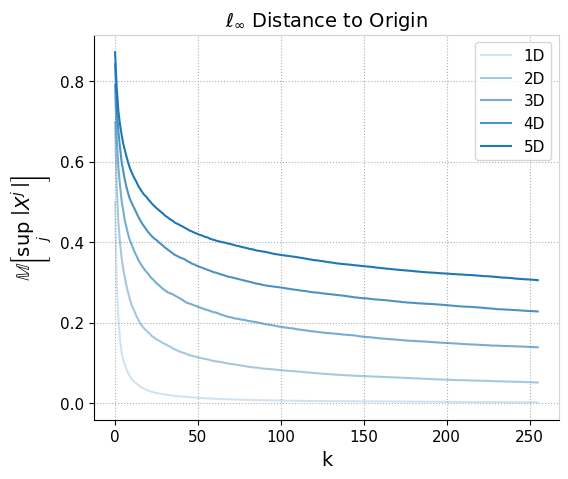

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
for n_dims in range(1, max_n_dims + 1):
    ns = np.arange(n_samples)
    xss = generator.uniform(-1, 1, size=(n_trials, n_samples, n_dims))
    dss = np.max(np.abs(xss), axis=2)
    dss_min = np.minimum.accumulate(dss, axis=1)
    ds_min_median = np.median(dss_min, axis=0)

    ax.plot(
        ns,
        ds_min_median,
        color="tab:blue",
        alpha=0.2 + 0.8 * (n_dims - 1) / (max_n_dims - 1),
        label=f"{n_dims}D",
    )

# Format the plot.
ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")
ax.legend()
ax.set_title(r"$\ell_\infty$ Distance to Origin")
ax.set_xlabel("k")
ax.set_ylabel(r"$\mathbb{M}\left[\sup_{j}\; \left|X^j\right|\right]$")

plt.show()

Mathematically, rate of convergence decreases exponentially in the dimension. Given $X_i \sim U[-1, 1]^d$:

$$ \mathbb{P}(\|X_i\|_\infty \leq \epsilon) = \epsilon^d $$

Thus, the expected number of draws to get $\epsilon$-close to the origin is $\left(\frac{1}{\epsilon}\right)^d$.

In summary: when random search works well, so too should our tail approximation. In high dimensions, random search converges slowly, thus the approximation converges slowly as well. One solution is to tighten the search space. With a tighter search space, the asymptotic approximation converges much faster&mdash;however, the right answer in such cases is probably to use something besides random search.

Luckily, random search works well for many problems of interest. For example, it is surprisingly effective for tuning hyperparameters [(Bergstra and Begnio, 2012)](https://jmlr.csail.mit.edu/papers/v13/bergstra12a.html). The reason is that random search's performance depends only on the *intrinsic* dimension of the optimization problem, or the dimensions along which performance actually changes. Even if you tune a dozen hyperparameters, typically only a 1 or 2 dimensional combination of them actually matters! Thus, we should expect that the tail approximation often works well in practice.

### Takeaways from Approximating the Tail

By Taylor expanding about the optimum, we derived an effective approximation to the score distribution's tail. This approximation becomes more accurate as the best value found by random search approaches the optimum. We can get closer to the optimum by either running more iterations of search or by tightening the search space.

When the optimization has low intrinsic dimension (1 to 3), random search works well and the tail approximation converges quickly. When the intrinsic dimension is higher, random search doesn't work and the approximation will be accurate only with a very tight search space.

Based on our approximation we have the following helpful formulas:

**Volume of the Hessian Ellipse**

Minimization:

$$
V(y) = (y - y_*)^{\frac{d}{2}} \left(\frac{\pi^{\frac{d}{2}}}{\Gamma\left(\frac{d}{2} + 1\right)}\prod_{j=1}^{d} \sqrt{\frac{2}{\lambda_j}}\right)
$$

Maximization:

$$
V(y) = (y^* - y)^{\frac{d}{2}} \left(\frac{\pi^{\frac{d}{2}}}{\Gamma\left(\frac{d}{2} + 1\right)}\prod_{j=1}^{d} \sqrt{- \frac{2}{\lambda_j}}\right)
$$

**Approximate CDF for the tail**

Minimization:

$$
F(y) \approx \frac{V(y)}{\prod_{j=1}^{d} (b_j - a_j)} = \frac{V(1 + y_*)}{\prod_{j=1}^{d} (b_j - a_j)} (y - y_*)^{\frac{d}{2}}
$$

Maximization:

$$
F(y) \approx 1 - \frac{V(y)}{\prod_{j=1}^{d} (b_j - a_j)} = 1 - \frac{V(y^* - 1)}{\prod_{j=1}^{d} (b_j - a_j)} (y^* - y)^{\frac{d}{2}}
$$

**Approximate median tuning curve**

Minimization:

$$
\tau_q(k) \approx y_* + \left[\frac{\prod_{j=1}^{d} (b_j - a_j)}{V(1 + y_*)} \left(1 - (1 - q)^\frac{1}{k}\right)\right]^\frac{2}{d}
$$

Maximization:

$$
\tau_q(k) \approx y^* - \left[\frac{\prod_{j=1}^{d} (b_j - a_j)}{V(y^* - 1)} \left(1 - q^\frac{1}{k}\right)\right]^\frac{2}{d}
$$

## The Quadratic Distribution

Consider the approximate CDF for the right tail when maximizing:

$$
F(y) \approx 1 - \frac{V(y^* - 1)}{\prod_{j=1}^{d} (b_j - a_j)} (y^* - y)^{\frac{d}{2}}
$$

If we take this approximation formula and replace some of the constants with parameters, it defines a parametric family:

$$ F(y; \omega, \beta, \gamma) = 1 - \omega(\beta - y)^\frac{\gamma}{2} $$

We call this family *the quadratic distribution*: $\mathcal{Q}(\omega, \beta, \gamma)$. This family is closely related to the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). In particular, it's closely related to a special case of the beta distribution: [the power function distribution](https://www.statisticshowto.com/power-function-distribution/) (see also [here](http://www.nematrian.com/PowerFunctionDistribution)). For maximization, we call it the *concave* quadratic distribution, and for minimization there is an analogous *convex* quadratic distribution.

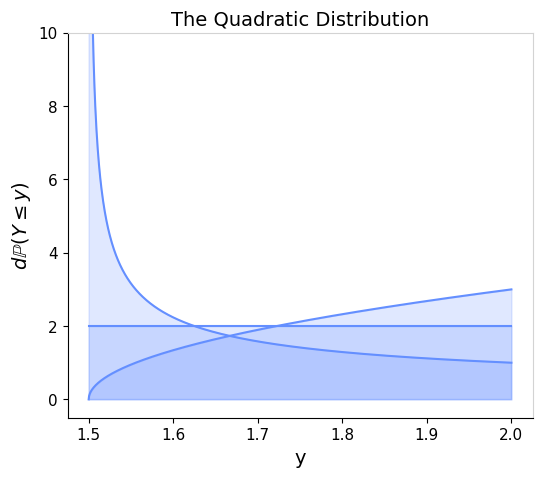

In [16]:
# Visualize the convex quadratic distribution.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
a, b, convex = 1.5, 2., True
for c in [1, 2, 3]:
    dist = QuadraticDistribution(a, b, c, convex)
    grid = np.linspace(a, b, num=1_024)

    # Plot the distribution.
    ax.plot(
        grid,
        dist.pdf(grid),
        linestyle="-",
        color=styles["empirical"]["color"],
    )
    ax.fill_between(
        grid,
        dist.pdf(grid),
        alpha=0.2,
        color=styles["empirical"]["color"],
    )

# Format the plot
ax.set_ylim(-0.5, 10)  # The density goes to infinity, so restrict the plot's range.

ax.grid(visible=False)
ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")

ax.set_xlabel("y")
ax.set_ylabel(r"$d\mathbb{P}(Y \leq y)$")
ax.set_title("The Quadratic Distribution")

plt.show()

### Understanding the Quadratic Distribution

Geometrically, the quadratic distribution arises from the following process. First, take a function of the form: $h(\pmb{x}) = \beta - \pmb{x}^T A \pmb{x}$ where $A$ is a positive semi-definite matrix and $\beta$ is a constant. Next, use the function to a define an ellipse: $h(\pmb{x}) \geq \alpha$. Then, sample a point, $\pmb{X}$, uniformly in that ellipse. Finally, report the function's value at that point: $Y = h(\pmb{X})$.

Let's further simplify this geometric intuition. By a change of coordinates, we can transform the original ellipse into a sphere. In the new coordinates, the distribution of $\pmb{X}$ is still uniform and the function, $h$, is just $\beta$ minus the squared distance from the origin. Thus, without loss of generality, we can think of this family as sampling a point in a $d$-ball and reporting the squared distance from the edge plus some offset. The maximum value is obtained at the center and the minimum on the boundary.

If we know the minimum value, then $\omega$ is determined as a normalizing constant. We can see this fact by conditioning on the minimum, $\alpha$:

$$
\begin{align*}
  \mathbb{P}(Y_i \leq y | y \geq \alpha) &= \frac{\mathbb{P}(\alpha \leq Y_i \leq y)}{\mathbb{P}(y \geq \alpha)} \\
                                         &= \mathbb{P}(\alpha \leq Y_i \leq y) \\
                                         &= \left(1 - \omega(\beta - y)^\frac{\gamma}{2}\right) - \left(1 - \omega(\beta - \alpha)^\frac{\gamma}{2}\right) \\
                                         &= \omega\left[(\beta - \alpha)^\frac{\gamma}{2} - (\beta - y)^\frac{\gamma}{2}\right] \\
\end{align*}
$$

And from the fact that $\mathbb{P}(Y_i \leq \beta | y \geq \alpha) = 1$ we have:

$$ \omega = \frac{1}{(\beta - \alpha)^\frac{\gamma}{2}} $$

Thus, there's an alternative, more interpretable parametrization:

$$ F(y; \alpha, \beta, \gamma) = 1 - \left(\frac{\beta - y}{\beta - \alpha}\right)^\frac{\gamma}{2} $$

Where $\alpha$ is the minimum, $\beta$ the maximum, and $\gamma$ is the effective dimension. This parametrization shows that the initial ellipse only determines the minimum, $\alpha$, and the quadratic function only determines maximum, $\beta$, and the effective dimension, $\gamma$ (i.e., the number of nonzero eigenvalues of $A$).

The quadratic distribution thus has three highly interpretable parameters:

- $\alpha$: The lowest value of the distribution.
- $\beta$: The highest value the distribution.
- $\gamma$: The effective dimension of the quadratic function.

These parameters have even nicer interpretations in terms of our tail approximation:

- $\alpha$: A measure of how much probability mass falls in the asymptotic regime.
- $\beta$: The best possible performance.
- $\gamma$: The effective number of hyperparameters, i.e. the number of dimensions that actually change the performance.

Most of the parameters keep the same interpretation, but $\alpha$ merits some discussion. Because we only approximate the upper *tail* of the distribution, $\alpha$ can **not** be interpreted as the worst possible performance. The tail approximation is only valid in the asymptotic regime&mdash;in other words, above some performance threshold, $\theta$. In general, $\alpha$ will be less than $\theta$ and thus in a part of the distribution that's used in the approximation only indirectly. As a result, what $\alpha$ actually controls is how much of probability mass lies above the threshold and *in the asymptotic regime*.

As $\alpha$ gets smaller, more probability mass falls *outside* the asymptotic regime. As $\alpha$ gets bigger, more mass falls inside of it. We can make this relationship explicit using the CDF. Let $p$ equal the probability of falling within the asymptotic regime, then:

$$
\begin{align*}
    p &= \mathbb{P}(Y \geq \theta) \\
      &= 1 - F(\theta; \alpha, \beta, \gamma) \\
      &= \left(\frac{\beta - \theta}{\beta - \alpha}\right)^\frac{\gamma}{2} \\
\end{align*}
$$

And thus:

$$
p = \left(\frac{\beta - \theta}{\beta - \alpha}\right)^\frac{\gamma}{2} \qquad \alpha = \beta - \left(\frac{1}{p}\right)^\frac{2}{\gamma} (\beta - \theta)
$$

The distance between $\alpha$ and $\beta$ is a multiple of the distance between $\theta$ and $\beta$ that depends nonlinearly on $p$. Both $\alpha$ and $p$ are increasing functions of each other. It is always true that $\alpha \leq \theta$ and when $\alpha = \theta$ the *entire* distribution lies in the asymptotic regime.

### Formulas for the Quadratic Distribution

Let's derive some formulas and properties for the quadratic distribution. Recall its CDF:

$$ F(y; \alpha, \beta, \gamma) = 1 - \left(\frac{\beta - y}{\beta - \alpha}\right)^\frac{\gamma}{2} $$

Differentiating the CDF yields the probability density:

$$ dF(y; \alpha, \beta, \gamma) = \frac{\gamma}{2(\beta - \alpha)} \left(\frac{\beta - y}{\beta - \alpha}\right)^{\frac{\gamma}{2} - 1} $$

By inverting the CDF, we obtain the quantile function:

$$ F^{-1}(q; \alpha, \beta, \gamma) = \beta - (\beta - \alpha) \left(1 - q\right)^\frac{2}{\gamma} $$

And plugging in $q^\frac{1}{k}$ we obtain the $q^{th}$ quantile tuning curve:

$$ \tau_q(k; \alpha, \beta, \gamma) = \beta - (\beta - \alpha)\left(1 - q^{\frac{1}{k}}\right)^{\frac{2}{\gamma}} $$

For the expected tuning curve, $\tau_e(k)$, it's generally true that:

$$
\begin{align*}
  \tau_e(k) &= \int_{\mathbb{R}} y dF_k(y) dy \\
            &= \int_{\mathbb{R}} y \frac{d}{dy} F(y)^k dy \\
            &= \int_{\mathbb{R}} y(k F(y)^{k-1}) dF(y) dy \\
            &= \int_0^1 (k p^{k-1}) F^{-1}(p) dp \\
\end{align*}
$$

Where the last step uses the change of variables $p = F(y)$. For our parametric family, this leads to:

$$
\begin{align*}
  \tau_e(k; \alpha, \beta, \gamma) &= \int_0^1 (k p^{k-1}) F^{-1}(p) dp \\
                                &= \int_0^1 k p^{k-1} \left(\beta - (\beta - \alpha)(1 - p)^{\frac{2}{\gamma}}\right) dp \\
                                &= \beta \int_0^1 k p^{k-1} dp - k (\beta - \alpha) \int_0^1 p^{k-1} (1 - p)^{\frac{2}{\gamma}} dp \\
                                &= \beta - (\beta - \alpha) k\,\text{Beta}\left(k, \frac{\gamma + 2}{\gamma}\right) \\
                                &= \beta - (\beta - \alpha) \frac{\Gamma(k + 1) \Gamma\left(\frac{\gamma + 2}{\gamma}\right)}{\Gamma\left(k + \frac{\gamma + 2}{\gamma}\right)} \\
\end{align*}
$$

Our discussion has focused on when we wish to *maximize* a score, in which case our function is *concave* near the optimum. We can also derive similar results for when we wish to *minimize* a score, in which case the function will be *convex*. Thus, there are two variants of the quadratic distribution: the *concave* and the *convex*, which we denote by $\mathcal{Q}_\max$ and $\mathcal{Q}_\min$ when it is not clear from context. We won't derive the convex quadratic distribution's formulas since the ideas are very similar; instead, we'll just summarize the results for both:

**$\mathcal{Q}_\max(\alpha, \beta, \gamma)$: Concave Quadratic Distribution Formulas:**

$$
dF(y; \alpha, \beta, \gamma) = \frac{\gamma}{2(\beta - \alpha)} \left(\frac{\beta - y}{\beta - \alpha}\right)^{\frac{\gamma}{2} - 1}
$$

$$
F(y; \alpha, \beta, \gamma) = 1 - \left(\frac{\beta - y}{\beta - \alpha}\right)^\frac{\gamma}{2}
$$

$$
F^{-1}(q; \alpha, \beta, \gamma) = \beta - (\beta - \alpha) \left(1 - q\right)^\frac{2}{\gamma}
$$

$$
\tau_q(k; \alpha, \beta, \gamma) = \beta - (\beta - \alpha)\left(1 - q^{\frac{1}{k}}\right)^{\frac{2}{\gamma}}
$$

$$
\tau_e(k; \alpha, \beta, \gamma) = \beta - (\beta - \alpha) \frac{\Gamma(k + 1) \Gamma\left(\frac{\gamma + 2}{\gamma}\right)}{\Gamma\left(k + \frac{\gamma + 2}{\gamma}\right)}
$$

**$\mathcal{Q}_\min(\alpha, \beta, \gamma)$: Convex Quadratic Distribution Formulas:**

$$
dF(y; \alpha, \beta, \gamma) = \frac{\gamma}{2(\beta - \alpha)} \left(\frac{y - \alpha}{\beta - \alpha}\right)^{\frac{\gamma}{2} - 1}
$$

$$
F(y; \alpha, \beta, \gamma) = \left(\frac{y - \alpha}{\beta - \alpha}\right)^\frac{\gamma}{2}
$$

$$
F^{-1}(q; \alpha, \beta, \gamma) = \alpha + (\beta - \alpha) q^\frac{2}{\gamma}
$$

$$
\tau_q(k; \alpha, \beta, \gamma) = \alpha + (\beta - \alpha) \left(1 - (1 - q)^{\frac{1}{k}}\right)^{\frac{2}{\gamma}}
$$

$$
\tau_e(k; \alpha, \beta, \gamma) = \alpha + (\beta - \alpha) \frac{\Gamma(k + 1) \Gamma\left(\frac{\gamma + 2}{\gamma}\right)}{\Gamma\left(k + \frac{\gamma + 2}{\gamma}\right)}
$$

### The Parameters of the Quadratic Distribution

As we've discussed, the quadratic distribution's parameters have nice interpretations:

**Concave**
- $\alpha$: A measure of how much probability mass falls in the asymptotic regime.
- $\beta$: The best possible performance.
- $\gamma$: The effective number of hyperparameters, i.e. the number of dimensions that actually change the performance.

For the convex quadratic distribution, the roles of $\alpha$ and $\beta$ get reversed. Because we're minimizing instead of maximizing, the lowest value ($\alpha$) instead of the highest value ($\beta$) is the best possible:

**Convex**
- $\alpha$: The best possible performance.
- $\beta$: A measure of how much probability mass falls in the asymptotic regime.
- $\gamma$: The effective number of hyperparameters, i.e. the number of dimensions that actually change the performance.

Let's examine how these parameters change the distribution:

Varying a
---------



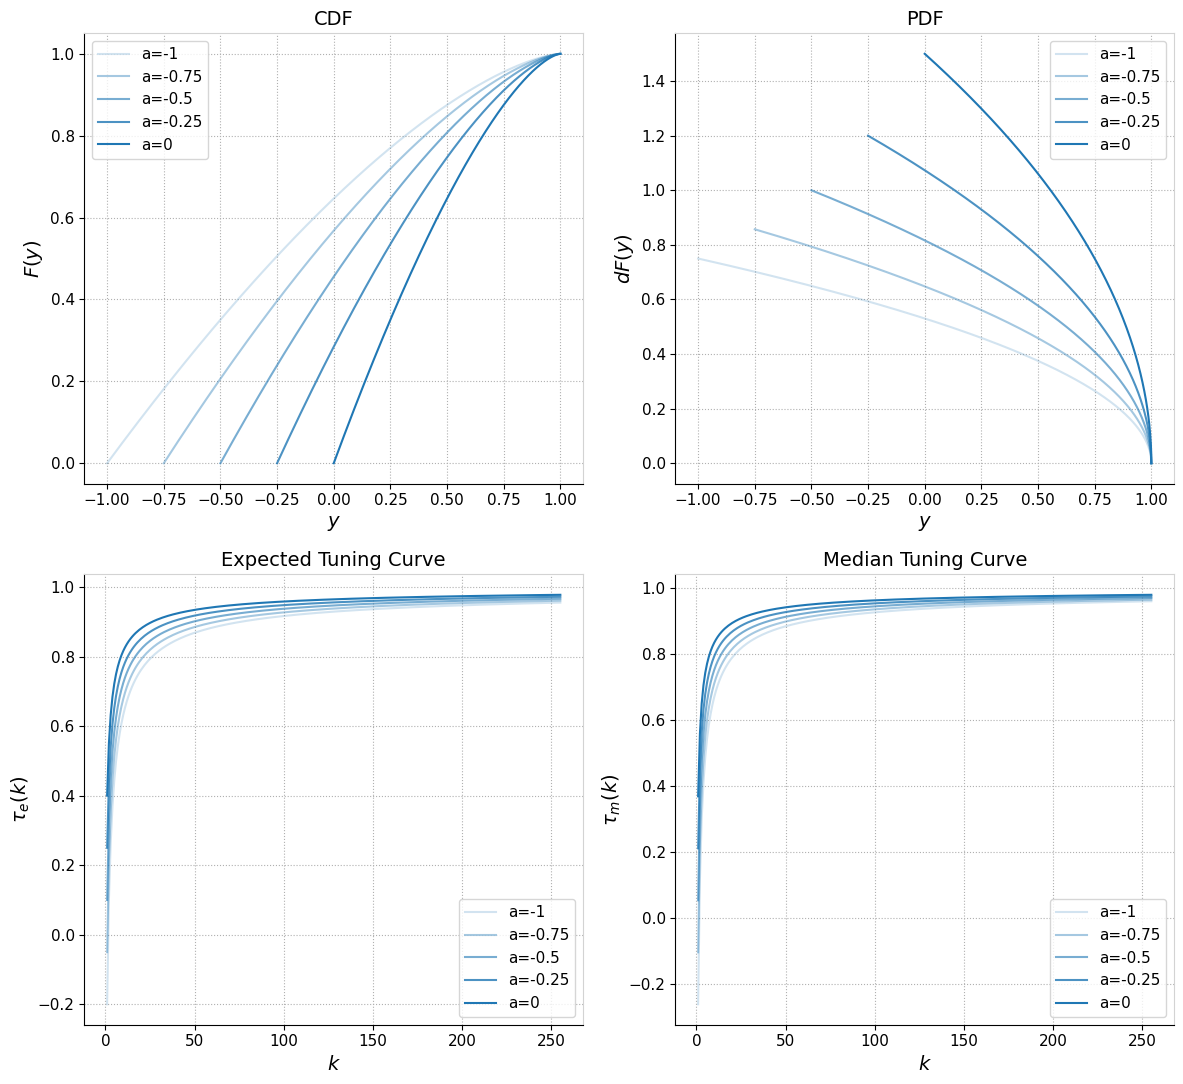

Varying b
---------



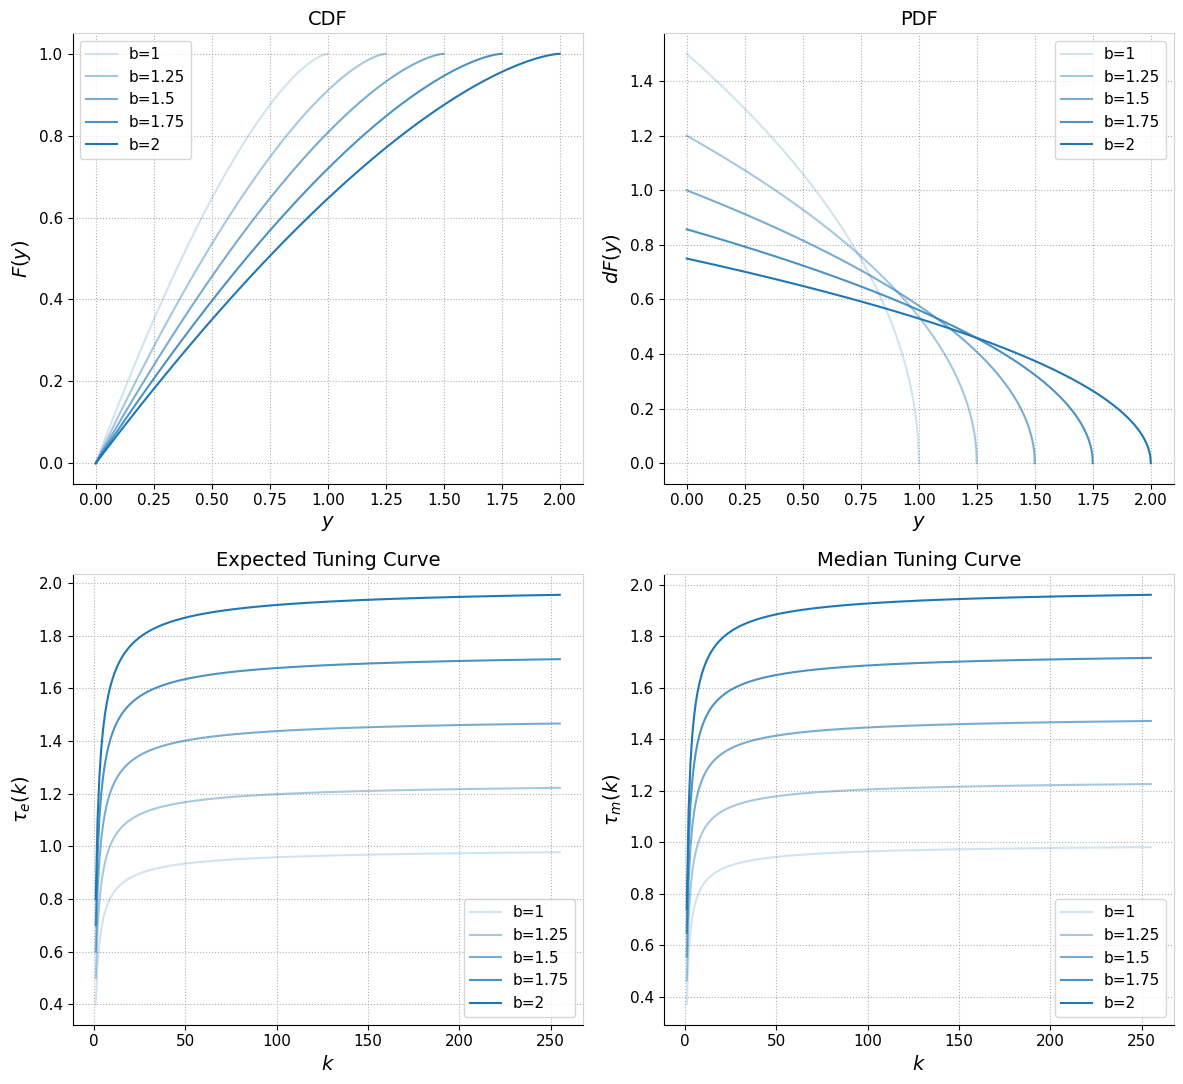

Varying c
---------



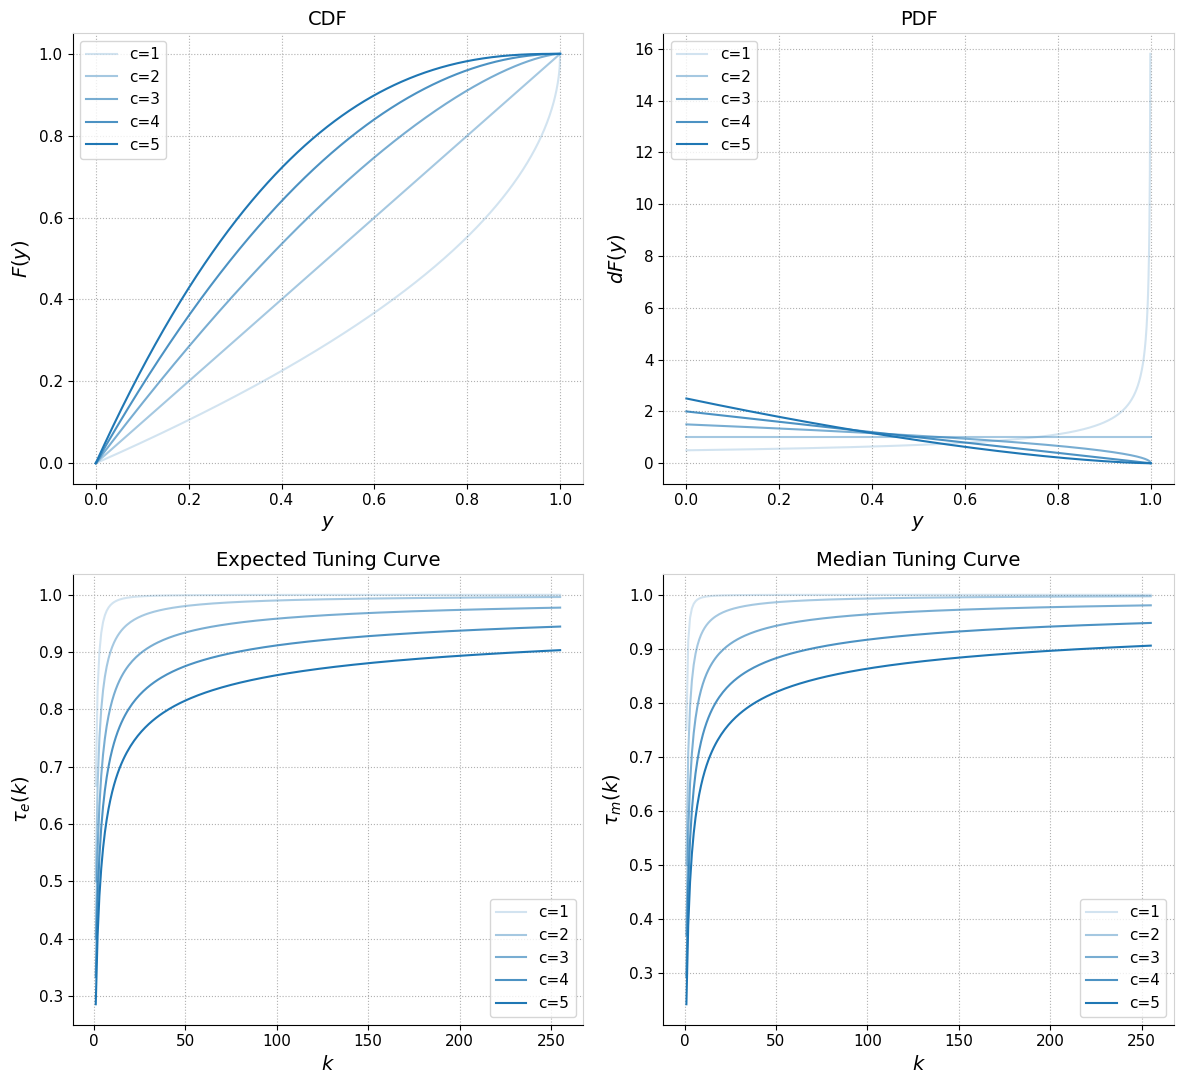

In [17]:
cases = {
    # param: (values, default)
    "a": ([-1, -0.75, -0.5, -0.25, 0], 0),
    "b": ([1, 1.25, 1.5, 1.75, 2], 1),
    "c": ([1, 2, 3, 4, 5], 3),
}
for case, (values, _) in cases.items():
    print(
        f"Varying {case}\n"
        f"---------\n",
    )

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 11))
    for i, value in enumerate(values):
        dist = QuadraticDistribution(**{
            param: default if param != case else value
            for param, (_, default) in cases.items()
        })

        ns = np.arange(1, n_samples)
        ys = np.linspace(dist.a, dist.b, num=1_000)

        axes[0, 0].plot(
            ys,
            dist.cdf(ys),
            c="tab:blue",
            alpha=0.2 + 0.8 * i / (len(values) - 1),
            label=f"{case}={value}",
        )
        axes[0, 1].plot(
            ys,
            dist.pdf(ys),
            c="tab:blue",
            alpha=0.2 + 0.8 * i / (len(values) - 1),
            label=f"{case}={value}",
        )
        axes[1, 0].plot(
            ns,
            dist.average_tuning_curve(ns),
            c="tab:blue",
            alpha=0.2 + 0.8 * i / (len(values) - 1),
            label=f"{case}={value}",
        )
        axes[1, 1].plot(
            ns,
            dist.quantile_tuning_curve(ns),
            c="tab:blue",
            alpha=0.2 + 0.8 * i / (len(values) - 1),
            label=f"{case}={value}",
        )

    # Format the plot.
    for i in range(2):
        for j in range(2):
            axes[i, j].spines["right"].set_color("lightgrey")
            axes[i, j].spines["top"].set_color("lightgrey")
            axes[i, j].legend()
            axes[i, j].set_xlabel("$y$" if i == 0 else "$k$")

    axes[0, 0].set_ylabel("$F(y)$")
    axes[0, 0].set_title("CDF")
    axes[0, 1].set_ylabel("$dF(y)$")
    axes[0, 1].set_title("PDF")
    axes[1, 0].set_ylabel(r"$\tau_e(k)$")
    axes[1, 0].set_title("Expected Tuning Curve")
    axes[1, 1].set_ylabel(r"$\tau_m(k)$")
    axes[1, 1].set_title("Median Tuning Curve")

    fig.tight_layout()

    plt.show()

### Other Properties of the Quadratic Distribution

The quadratic distribution has a number of interesting properties.

#### Moments

The quadratic distribution has the following formulas for its mean:

**convex**

$$
\mathbb{E}[Y] = \alpha + (\beta - \alpha) \frac{\gamma}{\gamma + 2},\qquad Y \sim \mathcal{Q}_\min(\alpha, \beta, \gamma)
$$

**concave**

$$
\mathbb{E}[Y] = \alpha + (\beta - \alpha) \frac{2}{\gamma + 2},\qquad Y \sim \mathcal{Q}_\max(\alpha, \beta, \gamma)
$$

In addition, the variance is always:

$$
\mathbb{V}[Y] = (\beta - \alpha)^2 \frac{4 \gamma}{(\gamma + 2)^2 (\gamma + 4)},\qquad Y \sim \mathcal{Q}(\alpha, \beta, \gamma)
$$

These formulas can be derived, for example, using the quadratic distribution's relationship to the beta distribution.

#### Duality

The quadratic distribution has a kind of dual relationship to itself. If you multiply it by a negative:

$$
Y \sim \mathcal{Q}_{\min}(\alpha, \beta, \gamma) \iff - Y \sim \mathcal{Q}_{\max}(-\beta, -\alpha, \gamma)
$$

Since multiplying by a negative reverses inequalities, it swaps the lower and upper bound parameters and changes minimization to maximization (and vice versa).

#### A Location-Scale Family

Another important property is that, if you fix $\gamma$, the quadratic distribution forms a [location-scale family](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family):

$$
Y \sim \mathcal{Q}(\alpha, \beta, \gamma) \iff c_0 + c_1 Y \sim \mathcal{Q}(c_0 + c_1 \alpha, c_0 + c_1 \beta, \gamma)\qquad c_0 \in \mathbb{R}, c_1 \in \mathbb{R}_{\geq 0}
$$

To get an intuition for this property, you can imagine the location and scale parameters as transforming the underlying quadratic function.

#### Standard Parametrization

Because of the location-scale property, we can reparametrize any quadratic distribution in terms of the standard quadratic distribution for that dimension: $S_\gamma \sim \mathcal{Q}(0, 1, \gamma)$:

$$
Y \sim \mathcal{Q}(\alpha, \beta, \gamma) \iff Y = \alpha + (\beta - \alpha) S_\gamma
$$

You can also parametrize the concave quadratic distribution in terms of the standard convex quadratic distribution: $S_{\min,\gamma} \sim \mathcal{Q}_\min(0, 1, \gamma)$:

$$
Y \sim \mathcal{Q}_\max(\alpha, \beta, \gamma) \iff Y = \beta - (\beta - \alpha) S_{\min,\gamma}
$$

And similarly with the roles reversed:

$$
Y \sim \mathcal{Q}_\min(\alpha, \beta, \gamma) \iff Y = \beta - (\beta - \alpha) S_{\max,\gamma}
$$

#### Conditioning on a Minimum (or Maximum)

An interesting property of the concave quadratic distribution is that conditioning on the sample minimum changes $\alpha$ but otherwise leaves the distribution unchanged:

$$ \mathbb{P}(Y_i \leq y | y \geq \alpha'; \alpha, \beta, \gamma) = \mathbb{P}(Y_i \leq y; \alpha', \beta, \gamma) $$

Geometrically, this happens because the conditioning shrinks the radius of the ellipse while leaving the dimensionality and value at the center intact. Unfortunately, no such regularity holds when conditioning on the sample maximum, since geometrically it puts a hole in the center of the ellipse.

Conversely, conditioning on the sample maximum has a similar effect on the convex quadratic distribution.

#### Sufficient Statistics

For the concave quadratic distribution, if the maximum ($\beta$) is known, we have the following minimal sufficient statistic:

$$ \min_{1\leq i\leq n} Y_i,\;\; \sum_{i=1}^n \log\left(\beta - Y_i\right) $$

It is sufficient since:

$$
\begin{align*}
  \prod_{i=1}^n dF(y_i; \alpha, \beta, \gamma) &= \prod_{i=1}^n \frac{\gamma}{2(\beta - \alpha)} \left(\frac{\beta - y_i}{\beta - \alpha}\right)^{\frac{\gamma}{2} - 1} \pmb{1}[y_i \geq \alpha] \\
                                            &= \left(\frac{\gamma}{2(\beta - \alpha)^\frac{\gamma}{2}}\right)^n \left(\prod_{i=1}^n (\beta - y_i)\right)^{\frac{\gamma}{2} - 1} \prod_{i=1}^n \pmb{1}[y_i \geq \alpha] \\
                                            &= \left(\frac{\gamma}{2(\beta - \alpha)^\frac{\gamma}{2}}\right)^n \exp\left(\sum_{i=1}^n \log(\beta - y_i)\right)^{\frac{\gamma}{2} - 1} \pmb{1}\left[\min_{1\leq i\leq n} y_i \geq \alpha\right] \\
                                            &= f\left(\sum_{i=1}^n \log(\beta - y_i); \alpha, \gamma\right) g\left(\min_{1\leq i\leq n} y_i; \alpha, \gamma\right) \\
\end{align*}
$$

Where:

$$
\begin{align*}
  f(x; \alpha, \gamma) &= \left(\frac{\gamma}{2(\beta - \alpha)^\frac{\gamma}{2}}\right)^n \exp\left(x\right)^{\frac{\gamma}{2} - 1} \\
  g(x; \alpha, \gamma) &= \pmb{1}[x \geq \alpha] \\
\end{align*}
$$

To see that the statistic is minimal sufficient, consider the ratio of likelihoods:

$$
\begin{align*}
  \prod_{i=1}^n \frac{dF(y_i; \alpha, \beta, \gamma)}{dF(y'_i; \alpha, \beta, \gamma)}
    &= \frac{\exp\left(\sum_{i=1}^n \log(\beta - y_i)\right)^{\frac{\gamma}{2} - 1} \pmb{1}\left[\min_{1\leq i\leq n} y_i \geq \alpha\right]}{\exp\left(\sum_{i=1}^n \log(\beta - y'_i)\right)^{\frac{\gamma}{2} - 1} \pmb{1}\left[\min_{1\leq i\leq n} y'_i \geq \alpha\right]} \\
    &= \exp\left(\sum_{i=1}^n \log(\beta - y_i) - \sum_{i=1}^n \log(\beta - y'_i)\right)^{\frac{\gamma}{2} - 1} \frac{\pmb{1}\left[\min_{1\leq i\leq n} y_i \geq \alpha\right]}{\pmb{1}\left[\min_{1\leq i\leq n} y'_i \geq \alpha\right]} \\
\end{align*}
$$

To make this one everywhere, we require:

$$ \sum_{i=1}^n \log(\beta - y_i) - \sum_{i=1}^n \log(\beta - y'_i) = 0 $$
$$ \frac{\pmb{1}\left[\min_{1\leq i\leq n} y_i \geq \alpha\right]}{\pmb{1}\left[\min_{1\leq i\leq n} y'_i \geq \alpha\right]} = 1 $$

Which are exactly the conditions:

$$ \min_{1\leq i\leq n} Y_i = \min_{1\leq i\leq n} Y'_i $$
$$ \sum_{i=1}^n \log\left(\beta - Y_i\right) = \sum_{i=1}^n \log\left(\beta - Y'_i\right) $$

For the convex case, we have equivalent results except interchanging the roles of $\alpha$ and $\beta$.

#### Related Distributions

As $\alpha, \beta \to c$, the quadratic distribution becomes a point mass at $c$:

$$
\mathcal{Q}(c, c, \gamma) = \delta_c
$$

And when $\gamma = 2$, the quadratic distribution is uniform between $\alpha$ and $\beta$:

$$
\mathcal{Q}(\alpha, \beta, 2) = \mathcal{U}(\alpha, \beta)
$$

In particular, when $\gamma = 2$ the convex and concave quadratic distributions are equal.

## The Noisy Quadratic Distribution

We've approximated the tail of the score distribution from random search, assuming that the score is a deterministic function of the input, $g(\pmb{X})$. In practice, this is often not the case. For example, when training a neural network many random factors affect the final performance, such as the initialization or data order.

In the stochastic case, assume the score is a function of $\pmb{X}$ plus some independent, identically distributed noise. For simplicity, assume the noise is Gaussian (though other distributions could also work in principle).

$$
Y = g(\pmb{X}) + E,\qquad E \sim \mathcal{N}\left(0, \sigma\right)
$$

As in the deterministic case, the tail of $Y$ will converge to a new parametric family of distributions which we call *the noisy quadratic distribution*: $\mathcal{Q}(\alpha, \beta, \gamma, \sigma)$.

Let's derive its properties!

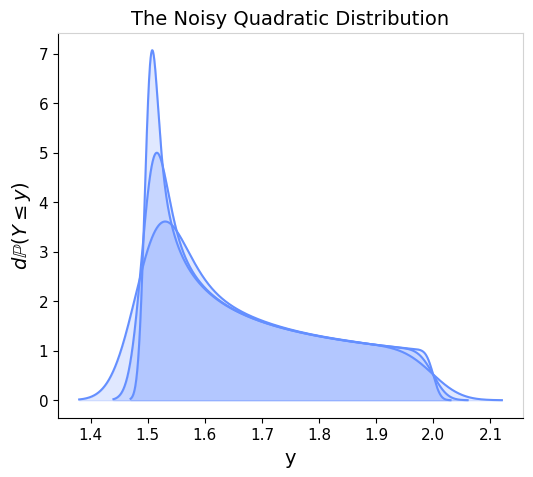

In [18]:
# Visualize the convex noisy quadratic distribution.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
a, b, c, convex = 1.5, 2., 1, True
for o in [1e-2, 2e-2, 4e-2]:
    dist = NoisyQuadraticDistribution(a, b, c, o, convex)
    grid = np.linspace(a - 3 * o, b + 3 * o, num=1_024)

    # Plot the distribution.
    ax.plot(
        grid,
        dist.pdf(grid),
        linestyle="-",
        color=styles["empirical"]["color"],
    )
    ax.fill_between(
        grid,
        dist.pdf(grid),
        alpha=0.2,
        color=styles["empirical"]["color"],
    )

# Format the plot
ax.grid(visible=False)
ax.spines["right"].set_color("lightgrey")
ax.spines["top"].set_color("lightgrey")

ax.set_xlabel("y")
ax.set_ylabel(r"$d\mathbb{P}(Y \leq y)$")
ax.set_title("The Noisy Quadratic Distribution")

plt.show()

### Understanding the Noisy Quadratic Distribution

In many ways, the noisy quadratic distribution is similar to the quadratic. To get an intuition for it, the most important *new* parameter is the ratio of the noise ($\sigma$) to the optimizable performance ($\beta - \alpha$):

$$
\frac{\sigma}{\beta - \alpha}
$$

This ratio determines the noisy quadratic distribution's shape. When analyzing random search, it is related to how much of the change in performance is due to better hyperparameters versus getting lucky with a particular training run (though for a complete picture, you must also consider where the asymptotic regime starts: $\theta$).

When the ratio is small, the noisy quadratic distribution behaves like the quadratic. When this ratio is large, it behaves like the normal.

### Formulas for the Noisy Quadratic Distribution

Unlike the quadratic distribution, the noisy quadratic distribution does not have simple formulas for its related functions. In general, the CDF, PDF, quantile, and related functions must be computed using more advanced numerical methods. Still, the noisy quadratic distribution has some formulas that are theoretically useful.

Consider the concave case. The noisy quadratic distribution is defined by the sum of quadratically and normally distributed random variables:

$$
Y \sim \mathcal{Q}_\max(\alpha, \beta, \gamma, \sigma) \iff Y = Q + E,\qquad Q \sim \mathcal{Q}_\max(\alpha, \beta, \gamma),\; E \sim \mathcal{N}(0, \sigma)
$$

The CDF of a sum can always be expressed as an expectation:

$$
F_Y(y) = \mathbb{E}\left[F_Q(y - E)\right]
$$

This expression can be reformulated in terms of the *partial fractional moments* of the normal distribution:

$$
F_Y(y) = \Phi\left(\frac{y - \alpha}{\sigma}\right) - \mathbb{E}_0^1\left[V^\frac{\gamma}{2}\right],\qquad V \sim \mathcal{N}\left(\frac{\beta - y}{\beta - \alpha}, \frac{\sigma}{\beta - \alpha}\right)
$$

Where $\Phi$ is the CDF of the standard normal distribution.

Similarly, the PDF of a sum can also be expressed as an expectation:

$$
f_Y(y) = \mathbb{E}\left[f_\mathcal{Q}(y - E)\right]
$$

Thus, we can obtain a similar formula for the PDF:

$$
f_Y(y) = \frac{\gamma}{2(\beta - \alpha)} \mathbb{E}_0^1\left[V^\frac{\gamma - 2}{2}\right],\qquad V \sim \mathcal{N}\left(\frac{\beta - y}{\beta - \alpha}, \frac{\sigma}{\beta - \alpha}\right)
$$

The quantile function and tuning curves may then be calculated numerically given the CDF and PDF.

Analogous formulas exist for the convex noisy quadratic distribution. Summarizing the results here:

**$\mathcal{Q}_\max(\alpha, \beta, \gamma, \sigma)$: Concave Noisy Quadratic Distribution Formulas:**

$$
dF(y; \alpha, \beta, \gamma, \sigma) = \frac{\gamma}{2(\beta - \alpha)} \mathbb{E}_0^1\left[V^\frac{\gamma - 2}{2}\right],\qquad V \sim \mathcal{N}\left(\frac{\beta - y}{\beta - \alpha}, \frac{\sigma}{\beta - \alpha}\right)
$$

$$
F(y; \alpha, \beta, \gamma, \sigma) = \Phi\left(\frac{y - \alpha}{\sigma}\right) - \mathbb{E}_0^1\left[V^\frac{\gamma}{2}\right],\qquad V \sim \mathcal{N}\left(\frac{\beta - y}{\beta - \alpha}, \frac{\sigma}{\beta - \alpha}\right)
$$

**$\mathcal{Q}_\min(\alpha, \beta, \gamma, \sigma)$: Convex Noisy Quadratic Distribution Formulas:**

$$
dF(y; \alpha, \beta, \gamma, \sigma) = \frac{\gamma}{2(\beta - \alpha)} \mathbb{E}_0^1\left[V^\frac{\gamma - 2}{2}\right],\qquad V \sim \mathcal{N}\left(\frac{y - \alpha}{\beta - \alpha}, \frac{\sigma}{\beta - \alpha}\right)
$$

$$
F(y; \alpha, \beta, \gamma, \sigma) = \Phi\left(\frac{y - \beta}{\sigma}\right) + \mathbb{E}_0^1\left[V^\frac{\gamma}{2}\right],\qquad V \sim \mathcal{N}\left(\frac{y - \alpha}{\beta - \alpha}, \frac{\sigma}{\beta - \alpha}\right)
$$

### The Parameters of the Noisy Quadratic Distribution

Like the quadratic distribution, the noisy quadratic distribution's parameters have nice interpretations.

The first three parameters, $\alpha$, $\beta$, and $\gamma$ have similar interpretations as in the quadratic distribution, except that now their interpretations are framed in terms of *expected* performance for a given choice of hyperparameters.

**Concave**
- $\alpha$: A measure of how much probability mass falls in the asymptotic regime.
- $\beta$: The best possible expected performance.
- $\gamma$: The effective number of hyperparameters, i.e. the number of dimensions that actually change the expected performance.
- $\sigma$: The variance in performance when training models with identical hyperparameters.

Again, the convex noisy quadratic distribution reverses the roles of $\alpha$ and $\beta$:

**Convex**
- $\alpha$: The best possible expected performance.
- $\beta$:  A measure of how much probability mass falls in the asymptotic regime.
- $\gamma$: The effective number of hyperparameters, i.e. the number of dimensions that actually change the expected performance.
- $\sigma$: The variance in performance when training models with identical hyperparameters.

Let's look at how these parameters affect the distribution:

Varying a
---------



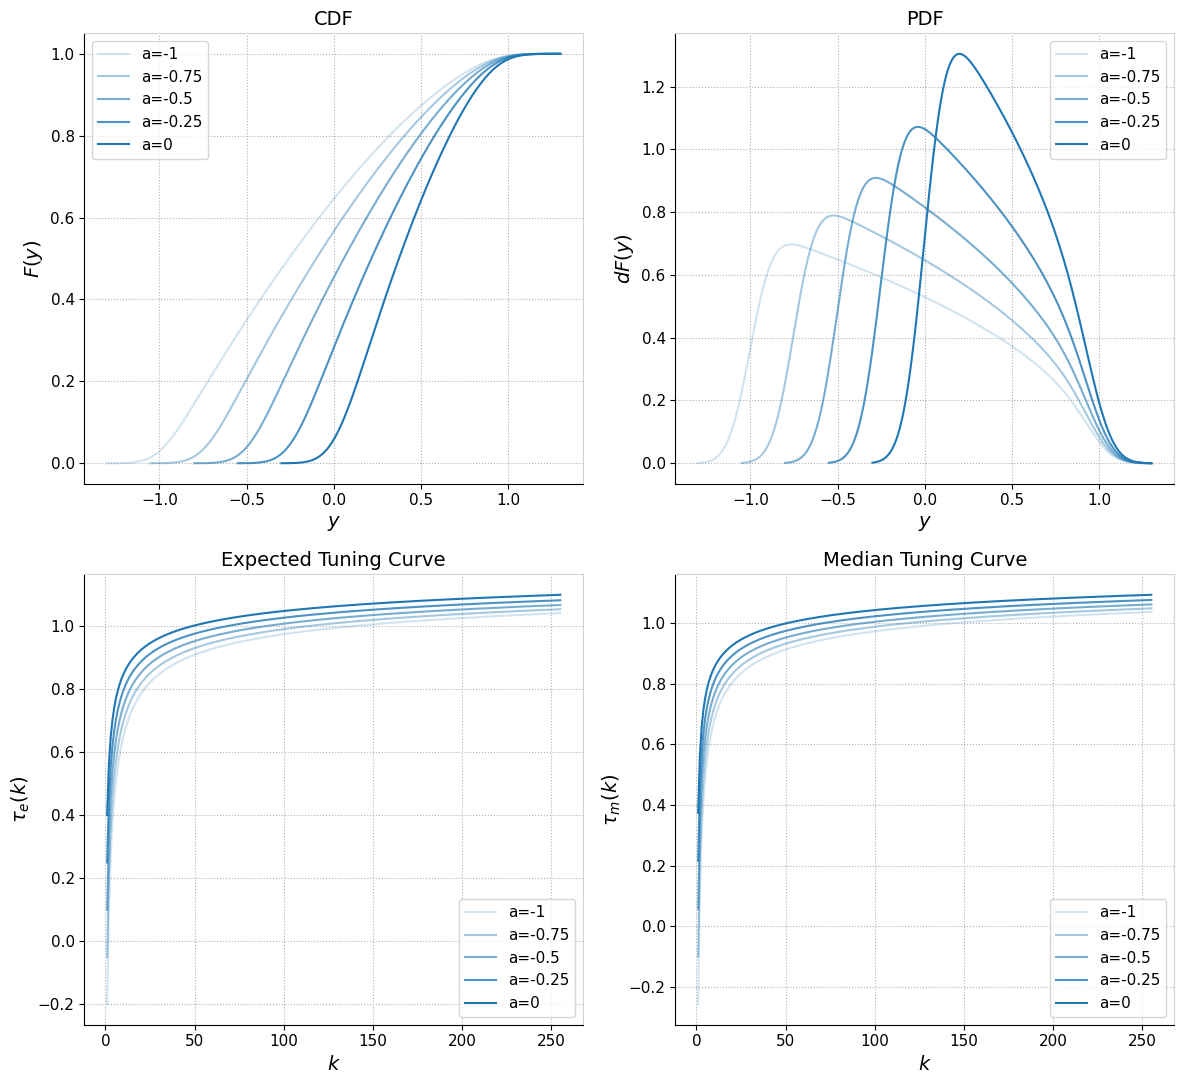

Varying b
---------



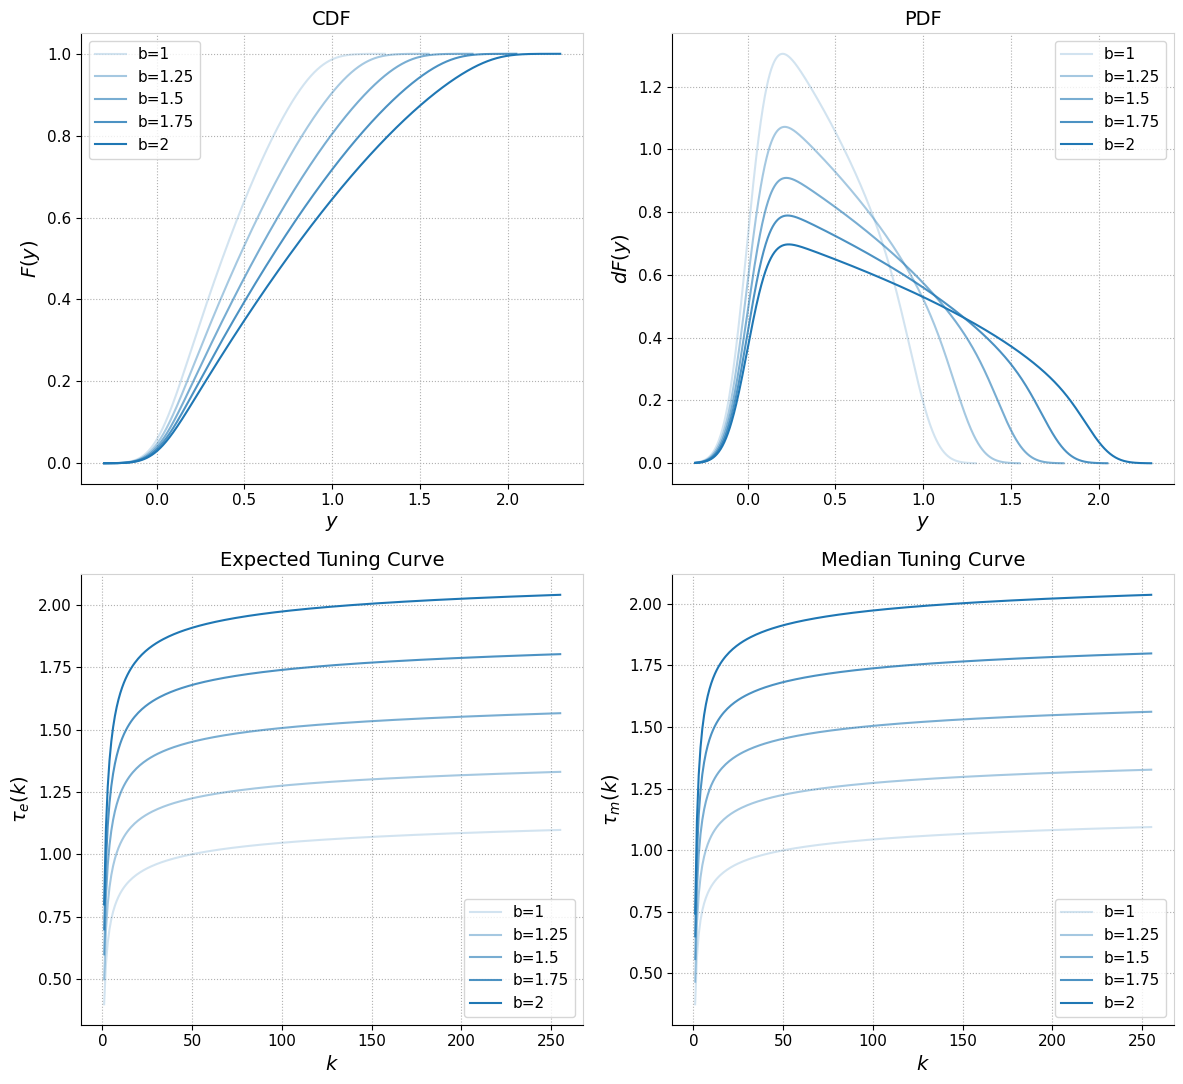

Varying c
---------



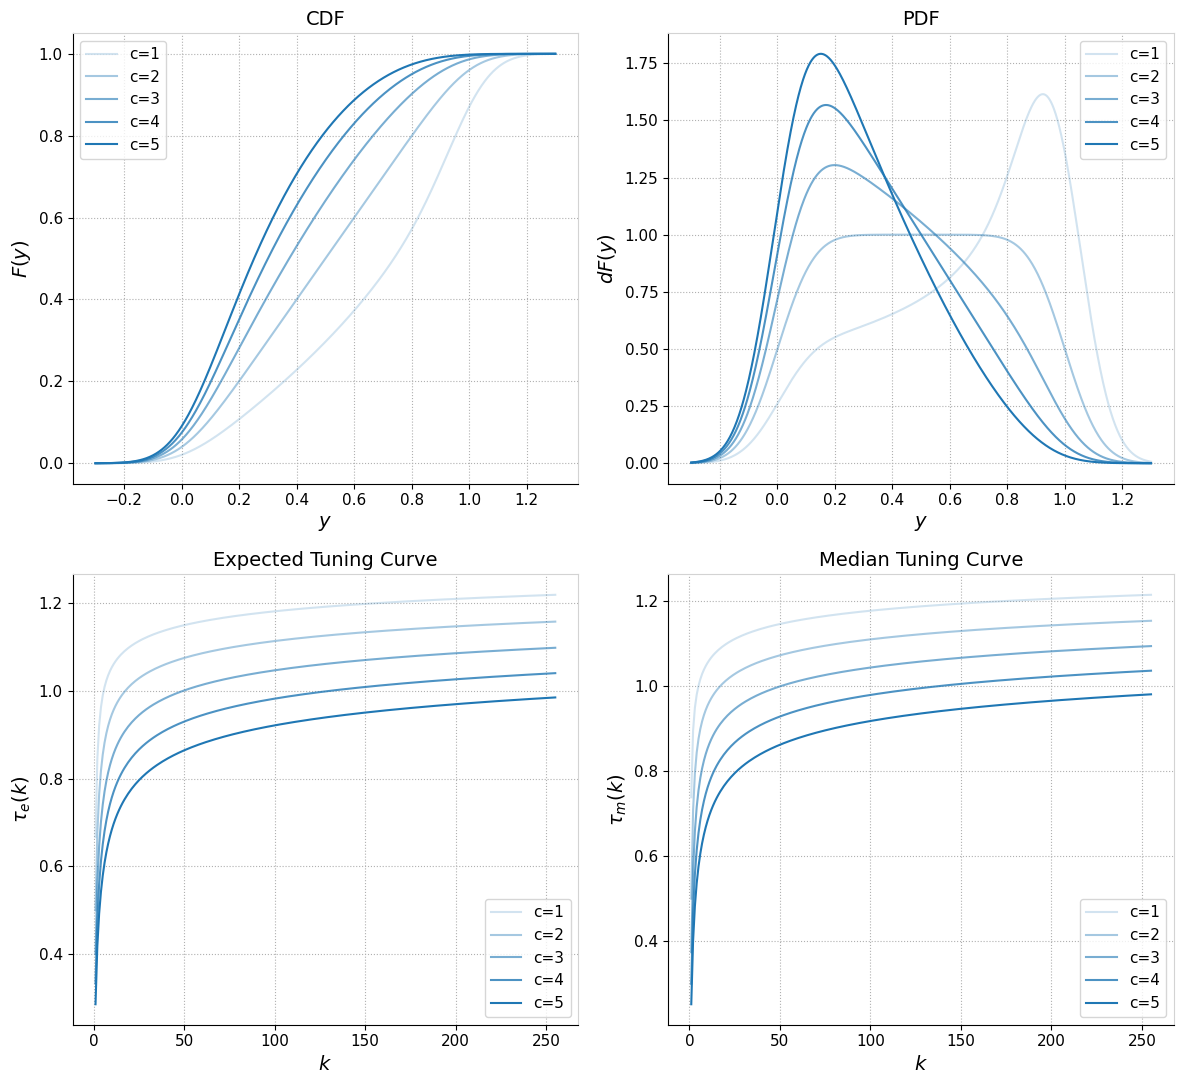

Varying o
---------



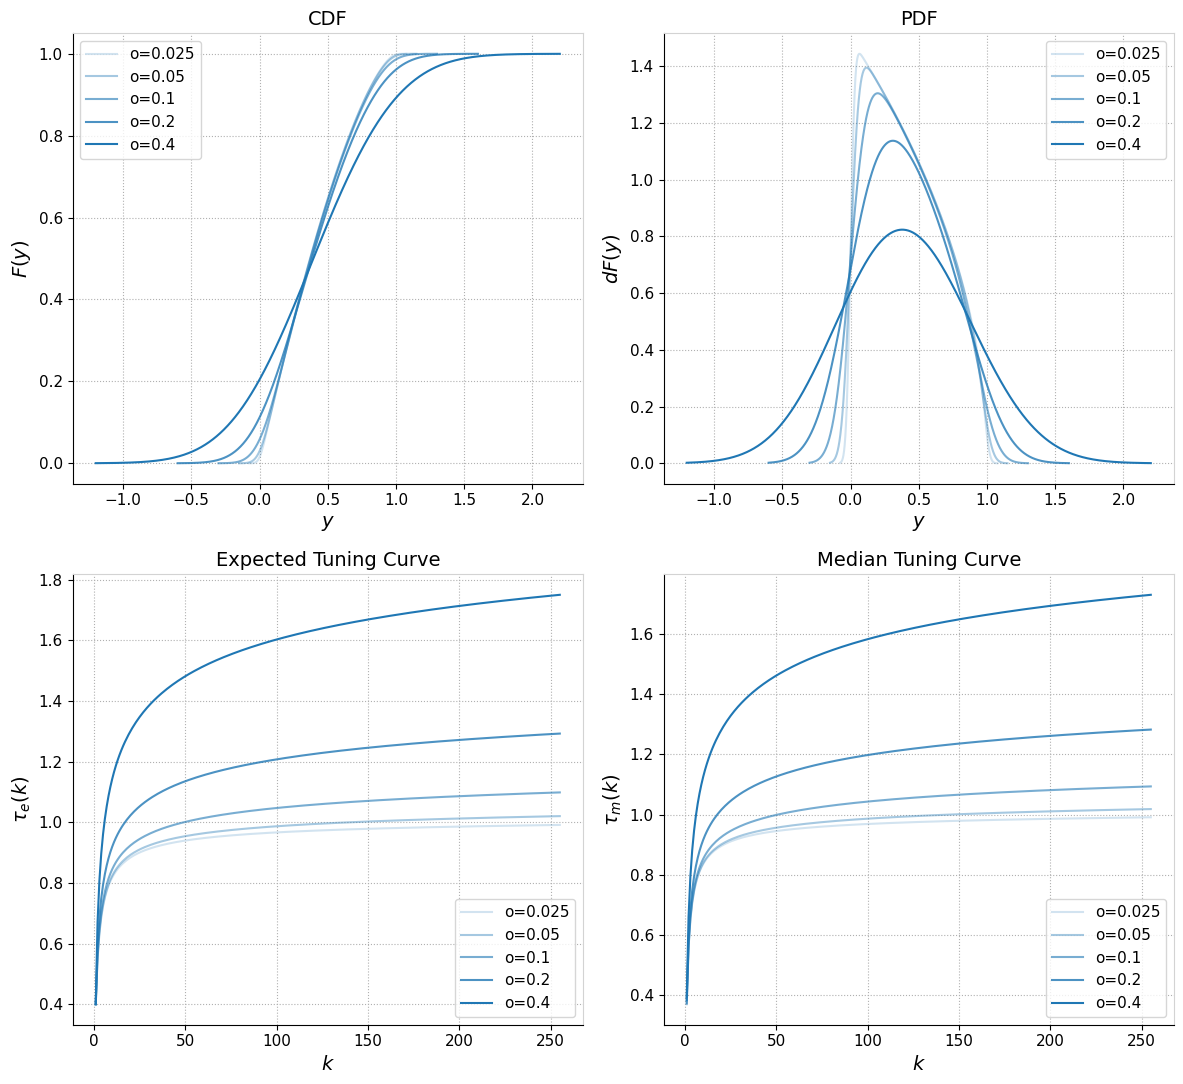

In [19]:
cases = {
    # param: (values, default)
    "a": ([-1, -0.75, -0.5, -0.25, 0], 0),
    "b": ([1, 1.25, 1.5, 1.75, 2], 1),
    "c": ([1, 2, 3, 4, 5], 3),
    "o": ([2.5e-2, 5e-2, 1e-1, 2e-1, 4e-1], 1e-1),
}
for case, (values, _) in cases.items():
    print(
        f"Varying {case}\n"
        f"---------\n",
    )

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 11))
    for i, value in enumerate(values):
        dist = NoisyQuadraticDistribution(**{
            param: default if param != case else value
            for param, (_, default) in cases.items()
        })

        ns = np.arange(1, n_samples)
        ys = np.linspace(
            dist.a - 3 * dist.o,
            dist.b + 3 * dist.o,
            num=1_000,
        )

        axes[0, 0].plot(
            ys,
            dist.cdf(ys),
            c="tab:blue",
            alpha=0.2 + 0.8 * i / (len(values) - 1),
            label=f"{case}={value}",
        )
        axes[0, 1].plot(
            ys,
            dist.pdf(ys),
            c="tab:blue",
            alpha=0.2 + 0.8 * i / (len(values) - 1),
            label=f"{case}={value}",
        )
        axes[1, 0].plot(
            ns,
            dist.average_tuning_curve(ns),
            c="tab:blue",
            alpha=0.2 + 0.8 * i / (len(values) - 1),
            label=f"{case}={value}",
        )
        axes[1, 1].plot(
            ns,
            dist.quantile_tuning_curve(ns),
            c="tab:blue",
            alpha=0.2 + 0.8 * i / (len(values) - 1),
            label=f"{case}={value}",
        )

    # Format the plot.
    for i in range(2):
        for j in range(2):
            axes[i, j].spines["right"].set_color("lightgrey")
            axes[i, j].spines["top"].set_color("lightgrey")
            axes[i, j].legend()
            axes[i, j].set_xlabel("$y$" if i == 0 else "$k$")

    axes[0, 0].set_ylabel("$F(y)$")
    axes[0, 0].set_title("CDF")
    axes[0, 1].set_ylabel("$dF(y)$")
    axes[0, 1].set_title("PDF")
    axes[1, 0].set_ylabel(r"$\tau_e(k)$")
    axes[1, 0].set_title("Expected Tuning Curve")
    axes[1, 1].set_ylabel(r"$\tau_m(k)$")
    axes[1, 1].set_title("Median Tuning Curve")

    fig.tight_layout()

    plt.show()

### Other Properties of the Noisy Quadratic Distribution

The noisy quadratic distribution also has several notable properties.

#### Moments

The formulas for the mean are the same as for the quadratic distribution:

**convex**

$$
\mathbb{E}[Y] = \alpha + (\beta - \alpha) \frac{\gamma}{\gamma + 2},\qquad Y \sim \mathcal{Q}_\min(\alpha, \beta, \gamma, \sigma)
$$

**concave**

$$
\mathbb{E}[Y] = \alpha + (\beta - \alpha) \frac{2}{\gamma + 2},\qquad Y \sim \mathcal{Q}_\max(\alpha, \beta, \gamma, \sigma)
$$

The formula for the variance just adds $\sigma^2$:

$$
\mathbb{V}[Y] = \sigma^2 + (\beta - \alpha)^2 \frac{4 \gamma}{(\gamma + 2)^2 (\gamma + 4)},\qquad Y \sim \mathcal{Q}(\alpha, \beta, \gamma, \sigma)
$$

These formulas can be derived using the sum definition of the noisy quadratic distribution.

#### Duality

The noisy quadratic distribution has the same dual relationship to itself as the quadratic distribution:

$$
Y \sim \mathcal{Q}_{\min}(\alpha, \beta, \gamma, \sigma) \iff - Y \sim \mathcal{Q}_{\max}(-\beta, -\alpha, \gamma, \sigma)
$$

The $\sigma$ parameter, like the $\gamma$ parameter, remains constant under the relationship. The reason is that the normal distribution is symmetric and $E$ is mean zero, so $-E$ has the same distribution as $E$.

#### Location-Scale Families

Like the quadratic distribution, the noisy quadratic also contains [location-scale families](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family). Unlike the quadratic distribution, these families do not map cleanly into the parameter space. Here is how the distribution changes under affine transformations:

$$
Y \sim \mathcal{Q}(\alpha, \beta, \gamma, \sigma) \iff c_0 + c_1 Y \sim \mathcal{Q}(c_0 + c_1 \alpha, c_0 + c_1 \beta, \gamma, c_1 \sigma)\qquad c_0 \in \mathbb{R}, c_1 \in \mathbb{R}_{\geq 0}
$$

The complication here is that multiplying by a constant modifies $\alpha$, $\beta$, and $\sigma$. Thus, while the noisy quadratic distribution is closed under affine transformations, we can't obtain a location-scale family by just fixing some of the parameters; rather the location-scale families exist on oblique half-planes through the parameter space, each corresponding to a fixed value of the ratio: $\frac{\sigma}{\beta - \alpha}$.

In this way, the parameter $\gamma$ and the *ratio* $\frac{\sigma}{\beta - \alpha}$ determine the shape of the distribution, while the other degrees of freedom just shift and scale it.

To get an intuition for why this is the case, consider how the transformation affects the underlying random variables whose sum defines the noisy quadratic:

$$
c_0 + c_1 Y = c_0 + c_1 (Q + E) = (c_0 + c_1 Q) + c_1 E
$$

The quadratic distribution is fully transformed while the noise gets scaled by $c_1$.

#### Standard Parametrization

Any noisy quadratic distribution can be reparametrized in terms of a standard noisy quadratic distribution for a given $\gamma$ and ratio $\frac{\sigma}{\beta - \alpha}$: $S_{\gamma,\frac{\sigma}{\beta - \alpha}} \sim \mathcal{Q}\left(0, 1, \gamma, \frac{\sigma}{\beta - \alpha}\right)$

$$
Y \sim \mathcal{Q}(\alpha, \beta, \gamma, \sigma) \iff Y = \alpha + (\beta - \alpha) S_{\gamma,\frac{\sigma}{\beta - \alpha}}
$$

Similarly, you can also parametrize the concave noisy quadratic distribution in terms of the standard convex noisy quadratic distribution: $S_{\min,\gamma,\frac{\sigma}{\beta - \alpha}} \sim \mathcal{Q}_\min\left(0, 1, \gamma, \frac{\sigma}{\beta - \alpha}\right)$:

$$
Y \sim \mathcal{Q}_\max(\alpha, \beta, \gamma, \sigma) \iff Y = \beta - (\beta - \alpha) S_{\min,\gamma,\frac{\sigma}{\beta - \alpha}}
$$

And again with the roles reversed:

$$
Y \sim \mathcal{Q}_\min(\alpha, \beta, \gamma, \sigma) \iff Y = \beta - (\beta - \alpha) S_{\max,\gamma,\frac{\sigma}{\beta - \alpha}}
$$

#### Related Distributions

As $\alpha, \beta \to c$ and $\sigma \to 0$, the noisy quadratic distribution becomes a point mass at $c$:

$$
\mathcal{Q}(c, c, \gamma, 0) = \delta_c
$$

The quadratic distribution is a special case of the noisy quadratic:

$$
\mathcal{Q}(\alpha, \beta, \gamma) = \mathcal{Q}(\alpha, \beta, \gamma, 0)
$$

This fact justifies our notation that uses $\mathcal{Q}$ for both.

Moreover, as $\frac{\sigma}{\beta - \alpha} \to 0$ the noisy quadratic distribution is well-approximated by a quadratic distribution. Intuitively, if the additive noise ($E$) is small relative to the change in expectation ($Q$), then we can ignore the noise in many scenarios.

At the other extreme, as $\frac{\sigma}{\beta - \alpha} \to \infty$ the noisy quadratic distribution is well-approximated by a normal distribution with the same mean and variance.

Finally, when $\gamma = 2$ the concave and convex noisy quadratic distributions are equal (though they are *not* uniformly distributed).

## Conclusion

We have asked: is there a parametric family that approximates the tail of the score distribution from random search? In fact, there is. We derived two variations on this theme.

**The Deterministic Case.** *If* (1) performance is a deterministic function of the hyperparameters, (2) that function is thrice differentiable at the optimum, and (3) the search distribution is approximately uniform near the optimum (i.e., absolutely continuous with respect to Lebesgue measure) *then* the tail of the score distribution converges to a *quadratic distribution*. The quadratic distribution has 3 interpretable parameters: the best possible performance, how much probability mass falls in the asymptotic regime, and the *effective* number of hyperparameters.

**The Stochastic Case.** *If* (1) performance is a deterministic function of the hyperparameters plus additive normal noise, (2) the expectated performance conditioned on the hyperparameters is thrice differentiable at the optimum, and (3) the search distribution is approximately uniform near the optimum (i.e., absolutely continuous with respect to Lebesgue measure) *then* the tail of the score distribution converges to a *noisy quadratic distribution*. The noisy quadratic distribution has 4 interpretable parameters: the best possible *expected* performance, how much probability mass falls in the asymptotic regime, the *effective* number of hyperparameters, and the standard deviation of the additive noise.

While we defined the noisy quadratic distribution assuming additive normal noise, in general most results still hold if we use any zero mean additive noise instead; however, normal noise covers most of the situations one encounters in practice.

Of course, in reality one never works with infinitely large samples or infinitely small regions about the optimum. The speed of convergence to a limit matters. To this end, using a uniform search distribution on an appropriate scale (e.g., a linear or a log scale) is useful to get faster convergence in actual applications.

Using these limit theorems, we can better understand and extrapolate random search and develop more powerful statistical tools for learning about our models.